In [150]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import statsmodels.api as sm
import pandas_datareader as pdr
import matplotlib.pyplot as plt

from statsmodels.regression.rolling import RollingOLS
from pandas.tseries.offsets import MonthEnd


In [151]:
'''Value Weighted 인지'''
#df = pd.read_csv('./DATA/Industry_Portfolio_monthly_equal_weighted.csv', index_col=0, parse_dates=True)
df = pd.read_csv('./DATA/Industry_Portfolio_monthly_value_weighted.csv', index_col=0, parse_dates=True)
df.index = [dt.datetime.strptime(x, '%Y%m') + MonthEnd() for x in df.index.astype(str)]
df.columns = [x.replace(' ', '') for x in df.columns]
df = df.replace(-99.99, np.NaN).dropna()
df = df[['Oil','Agric', 'Mines', 'Gold', 'Steel']]

'''Value Weighted를 위한 사이즈'''
df_size = pd.read_csv('./DATA/Industry_Portfolio_monthly_firm_size.csv', index_col=0, parse_dates=True)
df_size.index = [dt.datetime.strptime(x, '%Y%m') + MonthEnd() for x in df_size.index.astype(str)]
df_size.columns = [x.replace(' ', '') for x in df_size.columns]
df_size = df_size.replace(-99.99, np.NaN).dropna()
df_size = df_size[['Oil','Agric', 'Mines', 'Gold', 'Steel']].apply(lambda x : x/x.sum(), axis=1)

com_df = pd.read_csv('./DATA/Commodity_index.csv', index_col=0, parse_dates=True).sort_index()
com_df = com_df.resample('m').last()
com_df.index = [dt.datetime.strptime(f"{x.year}-{x.month}", '%Y-%m') + MonthEnd() for x in com_df.index]

#spx = yf.download('^GSPC', progress=False)[['Close']].rename(columns={'Close':'SPX'})
spx = pd.read_csv('./DATA/SPX500.csv', index_col=0, parse_dates=True)
spx = spx.resample('m').last()
spx.index = [dt.datetime.strptime(f"{x.year}-{x.month}", '%Y-%m') + MonthEnd() for x in spx.index]

rf = pdr.get_data_fred('DGS10', start="1970-01-01", end='2023-05-18').astype(float).rename(columns={'DGS10':'rf'})
rf = rf.resample('m').last()
rf.index = [dt.datetime.strptime(f"{x.year}-{x.month}", '%Y-%m') + MonthEnd() for x in rf.index]

# Broad Check

In [6]:
# ttt = df_size[['Agric', 'Oil', 'Mines', 'Gold']].copy()
# ttt['Mines'] = ttt['Mines'] + df_size['Steel']

# tt = pd.DataFrame(np.diag(com_df.pct_change().fillna(0).iloc[:-2, 0:-1] @ ttt.iloc[6:].T.values), index=ttt.iloc[6:].index, columns=['Broad'])

# t = pd.concat([broad_nre, idx_ret, tt], axis=1).dropna()



# x = t.iloc[:, 1:]
# x = sm.add_constant(x)
# y = t.iloc[:, 0]

# reg = RollingOLS(y, x, window=120).fit()

# plt.figure(figsize=(12, 4))
# plt.title('Broad NRE Beta')
# plt.plot(reg.params['SPX'].loc[:'2015'].dropna(), label=r'$\beta_{spx}$')
# plt.plot(reg.params['Broad'].loc[:'2015'].dropna(), label=r'$\beta_{commodity}$')
# #plt.ylim(0, 1.4)
# plt.grid()
# plt.legend()
# plt.show()

In [152]:
def plotting_crisis(start_date, end_date):
    plt.axvline(dt.datetime.strptime(start_date, '%Y-%m-%d'), color='k', linewidth=0.2)
    plt.axvline(dt.datetime.strptime(end_date,   '%Y-%m-%d'), color='k', linewidth=0.2)
    plt.axvspan(dt.datetime.strptime(start_date, '%Y-%m-%d'), dt.datetime.strptime(end_date, '%Y-%m-%d'), alpha=0.2, color='k')
    return

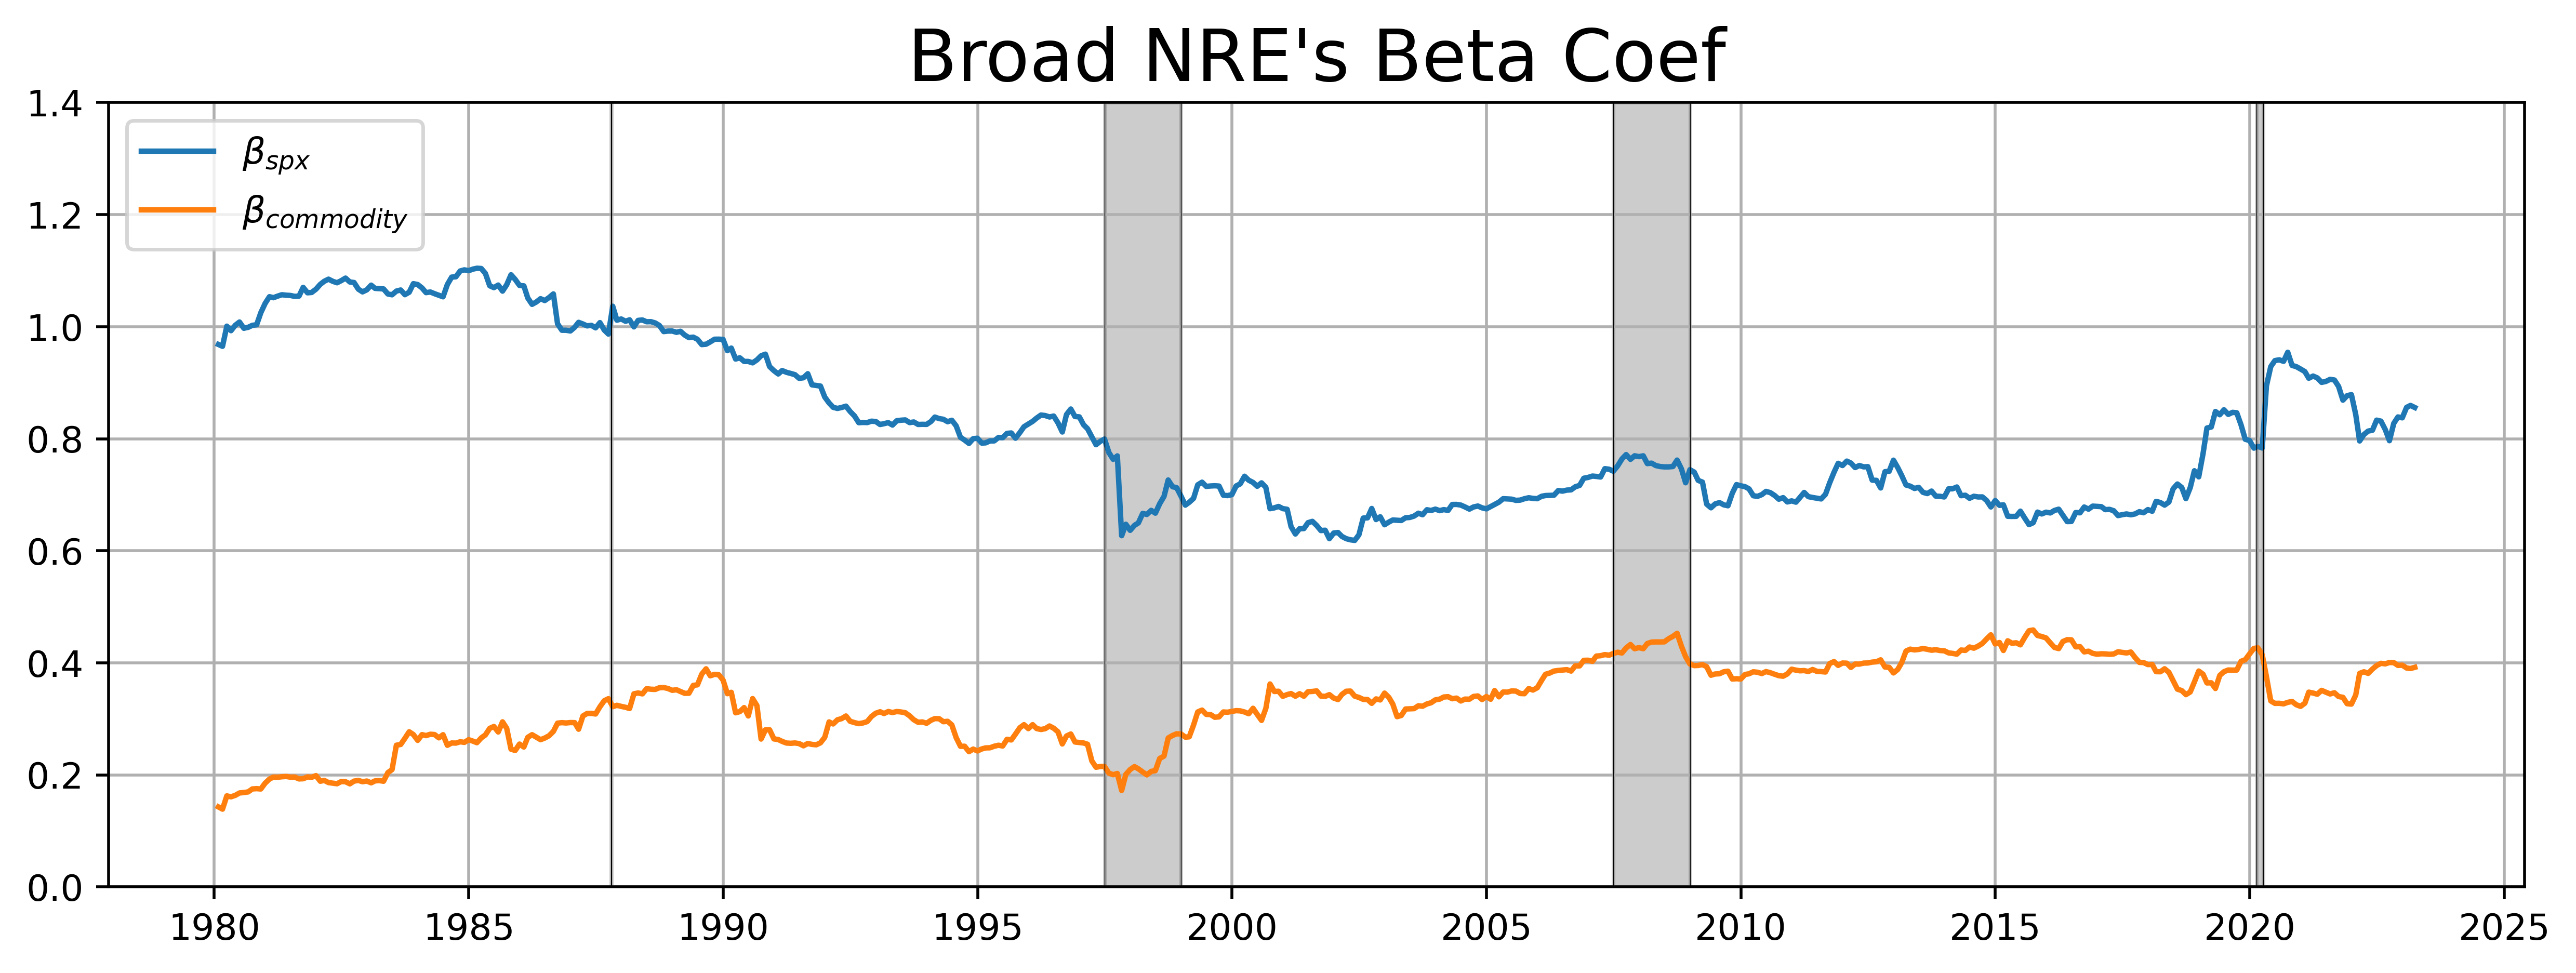

In [223]:
#broad_nre = pd.DataFrame(df.mean(axis=1), columns=['NRE']).apply(lambda x: x/100)
broad_nre = pd.DataFrame(np.diag(df @ df_size.T), index=df_size.index, columns=['NRE']).apply(lambda x:x/100)

broadcom_ret = com_df.pct_change().Broad.dropna()
#broadcom_ret = pd.DataFrame(com_df.iloc[:, 0:4].pct_change().mean(axis=1))
broadcom_ret.columns = ['Broad']

idx_ret = spx.pct_change().dropna()

test = pd.concat([broad_nre, idx_ret, broadcom_ret], axis=1).dropna()

x = test.iloc[:, 1:]
x = sm.add_constant(x)
y = test.iloc[:, 0]

reg = RollingOLS(y, x, window=120).fit()

reg.params.iloc[:, 1:].dropna()

plt.figure(figsize=(12, 4), dpi=500)
plt.title("Broad NRE's Beta Coef", size=20)
# plt.plot(reg.params['SPX'].loc[:'2015'].dropna(), label=r'$\beta_{spx}$')
# plt.plot(reg.params['Broad'].loc[:'2015'].dropna(), label=r'$\beta_{commodity}$')

plt.plot(reg.params['SPX'].dropna(), label=r'$\beta_{spx}$')
plt.plot(reg.params['Broad'].dropna(), label=r'$\beta_{commodity}$')

plotting_crisis('1987-10-19', '1987-10-24') # black monday
#plotting_crisis('1995-01-01', '2001-12-31') # Dotcom Bubble
plotting_crisis('1997-07-01', '1998-12-31') # Asian Financial Crisis
plotting_crisis('2007-07-01', '2008-12-31') # Subprime Mortgage Crisis
#plotting_crisis('2009-10-01', '2011-04-30') # Euro-zone Default Risk
plotting_crisis('2020-02-20', '2020-04-07') # Covid-19


plt.ylim(0, 1.4)
plt.grid()
plt.legend()
plt.show()

In [219]:
reg.params.dropna()

const       SPX     Broad
1980-01-31  0.008175  0.968179  0.142803
1980-02-29  0.008929  0.964936  0.138875
1980-03-31  0.008132  1.000875  0.162565
1980-04-30  0.008285  0.992793  0.160885
1980-05-31  0.007767  1.002627  0.163552
...              ...       ...       ...
2022-11-30 -0.001092  0.838845  0.395405
2022-12-31 -0.001118  0.837297  0.395837
2023-01-31 -0.000732  0.855929  0.390813
2023-02-28 -0.000774  0.859454  0.389846
2023-03-31 -0.000905  0.855680  0.392016

[519 rows x 3 columns]

In [154]:
print('''Mean T_stat''')
pd.DataFrame(reg.tvalues, index=reg.params.index, columns=reg.params.columns).dropna().iloc[:,1:].mean()

Mean T_stat


SPX      11.360522
Broad     5.817694
dtype: float64

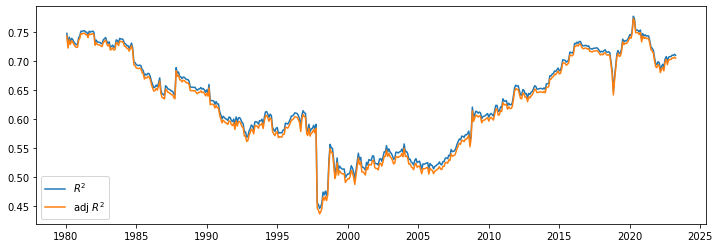

In [155]:
plt.figure(figsize=(12, 4))
plt.plot(reg.rsquared, label=r'$R^2$')
plt.plot(reg.rsquared_adj, label=r'adj $R^2$')
plt.legend()
plt.show()

In [156]:
print('''mean R''')
reg.rsquared.mean(), reg.rsquared_adj.mean()

mean R


(0.6325331052747744, 0.6262516198948564)

In [157]:
broad_betas = reg.params.dropna().iloc[:,1:]
broad_betas

SPX     Broad
1980-01-31  0.968179  0.142803
1980-02-29  0.964936  0.138875
1980-03-31  1.000875  0.162565
1980-04-30  0.992793  0.160885
1980-05-31  1.002627  0.163552
...              ...       ...
2022-11-30  0.838845  0.395405
2022-12-31  0.837297  0.395837
2023-01-31  0.855929  0.390813
2023-02-28  0.859454  0.389846
2023-03-31  0.855680  0.392016

[519 rows x 2 columns]

## replicate port

### $$ \beta_{\text{SI}}\quad \beta_{\text{CI}}\quad(1-\beta_{\text{SI}}-\beta_{\text{CI}})$$

In [161]:
broad_betas['cash'] = broad_betas.apply(lambda x : (1-x.iloc[0]-x.iloc[1]), axis=1).copy()
print(broad_betas.sum(axis=1).sum())
broad_betas

519.0


SPX     Broad      cash
1980-01-31  0.968179  0.142803 -0.110983
1980-02-29  0.964936  0.138875 -0.103811
1980-03-31  1.000875  0.162565 -0.163440
1980-04-30  0.992793  0.160885 -0.153677
1980-05-31  1.002627  0.163552 -0.166179
...              ...       ...       ...
2022-11-30  0.838845  0.395405 -0.234250
2022-12-31  0.837297  0.395837 -0.233134
2023-01-31  0.855929  0.390813 -0.246743
2023-02-28  0.859454  0.389846 -0.249300
2023-03-31  0.855680  0.392016 -0.247696

[519 rows x 3 columns]

In [14]:
'''다음기 수익률 매핑'''
ret_df = pd.concat([spx.pct_change(), com_df[['Broad']].pct_change(), rf.apply(lambda x: x/100)], axis=1).dropna().shift(-1).loc[broad_betas.index]
'''rf 수익률 사용할 때 1달 투자니 x/12로 해야함'''
ret_df.rf = ret_df.rf.apply(lambda x: x/12)
ret_df

SPX     Broad        rf
1980-01-31 -0.004380 -0.011959  0.010600
1980-02-29 -0.101795 -0.127618  0.010533
1980-03-31  0.041140  0.038433  0.008967
1980-04-30  0.046571  0.059591  0.008542
1980-05-31  0.026969  0.067799  0.008408
...              ...       ...       ...
2022-11-30 -0.058971 -0.017770  0.003233
2022-12-31  0.061753 -0.006581  0.002933
2023-01-31 -0.026112 -0.039916  0.003267
2023-02-28  0.035052 -0.013477  0.002900
2023-03-31  0.014642 -0.015777  0.002867

[519 rows x 3 columns]

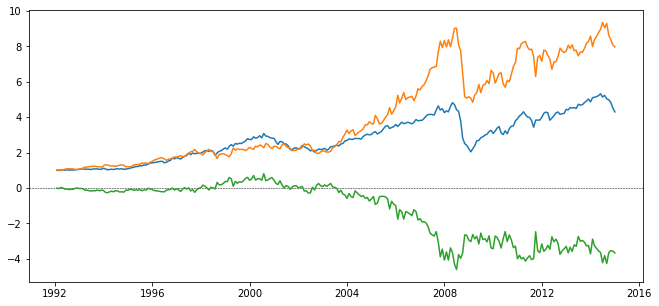

In [15]:
broad_pnl = pd.DataFrame(np.diag(ret_df @ broad_betas.values.T), columns=['pnl'], index=ret_df.index)
ex_broad_cum_ret = (1+broad_pnl.loc['1992':'2014']).cumprod() - (1+broad_nre.loc['1992':'2014']).cumprod().values

plt.figure(figsize=(11,5))
plt.plot((1+broad_pnl.loc['1992':'2014']).cumprod())
plt.plot((1+broad_nre.loc['1992':'2014']).cumprod())
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.plot(ex_broad_cum_ret)


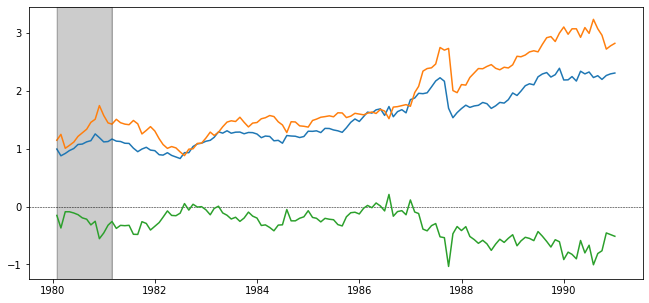

In [16]:
ex_broad_cum_ret = (1+broad_pnl).cumprod() - (1+broad_nre.loc[broad_pnl.index]).cumprod().values
plt.figure(figsize=(11,5))
plt.plot((1+broad_pnl.loc[:'1990']).cumprod())
plt.plot((1+broad_nre.loc[broad_pnl.index[0]:'1990']).cumprod())
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)


plotting_crisis('1980-01-31', '1981-03-01') # 2nd oil shock 
# plotting_crisis('1987-10-19', '1987-10-24') # black monday
# plotting_crisis('1995-01-01', '2001-12-31') # Dotcom Bubble
# plotting_crisis('1997-07-01', '1998-12-31') # Asian Financial Crisis
# plotting_crisis('2007-07-01', '2008-12-31') # Subprime Mortgage Crisis
# plotting_crisis('2009-10-01', '2011-04-30') # Euro-zone Default Risk
# plotting_crisis('2020-02-20', '2020-04-07') # Covid-19

plt.plot(ex_broad_cum_ret.loc[:'1990'])

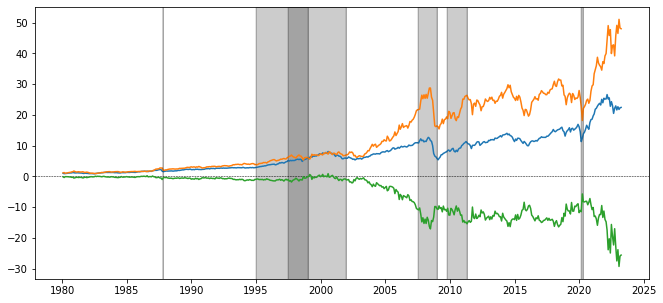

In [17]:
ex_broad_cum_ret = (1+broad_pnl).cumprod() - (1+broad_nre.loc[broad_pnl.index]).cumprod().values
plt.figure(figsize=(11,5))
plt.plot((1+broad_pnl).cumprod())
plt.plot((1+broad_nre.loc[broad_pnl.index]).cumprod())
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)

plotting_crisis('1987-10-19', '1987-10-24') # black monday
plotting_crisis('1995-01-01', '2001-12-31') # Dotcom Bubble
plotting_crisis('1997-07-01', '1998-12-31') # Asian Financial Crisis
plotting_crisis('2007-07-01', '2008-12-31') # Subprime Mortgage Crisis
plotting_crisis('2009-10-01', '2011-04-30') # Euro-zone Default Risk
plotting_crisis('2020-02-20', '2020-04-07') # Covid-19

plt.plot(ex_broad_cum_ret)

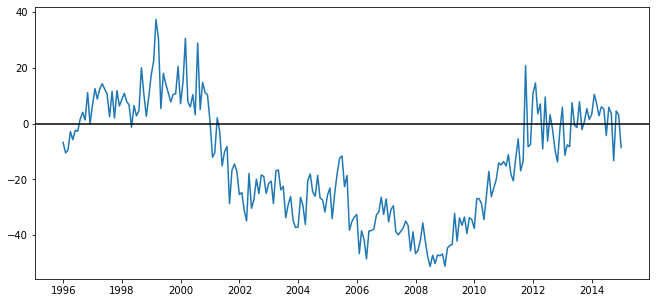

In [18]:
test = (broad_pnl - broad_nre.loc[broad_pnl.index].values)

plt.figure(figsize=(11,5))
plt.plot(((test.loc['1993':'2014'] + 1).rolling(36).apply(pd.Series.prod) - 1).apply(lambda x: x*100).dropna())
plt.axhline(0, color='k')
plt.show()

In [19]:
print('''Mean Beta''')
reg.params.iloc[:, 1:].mean()

Mean Beta


SPX      0.81766
Broad    0.32854
dtype: float64

# 전체 돌리기

In [20]:
df.columns.to_list()

['Oil', 'Agric', 'Mines', 'Gold', 'Steel']

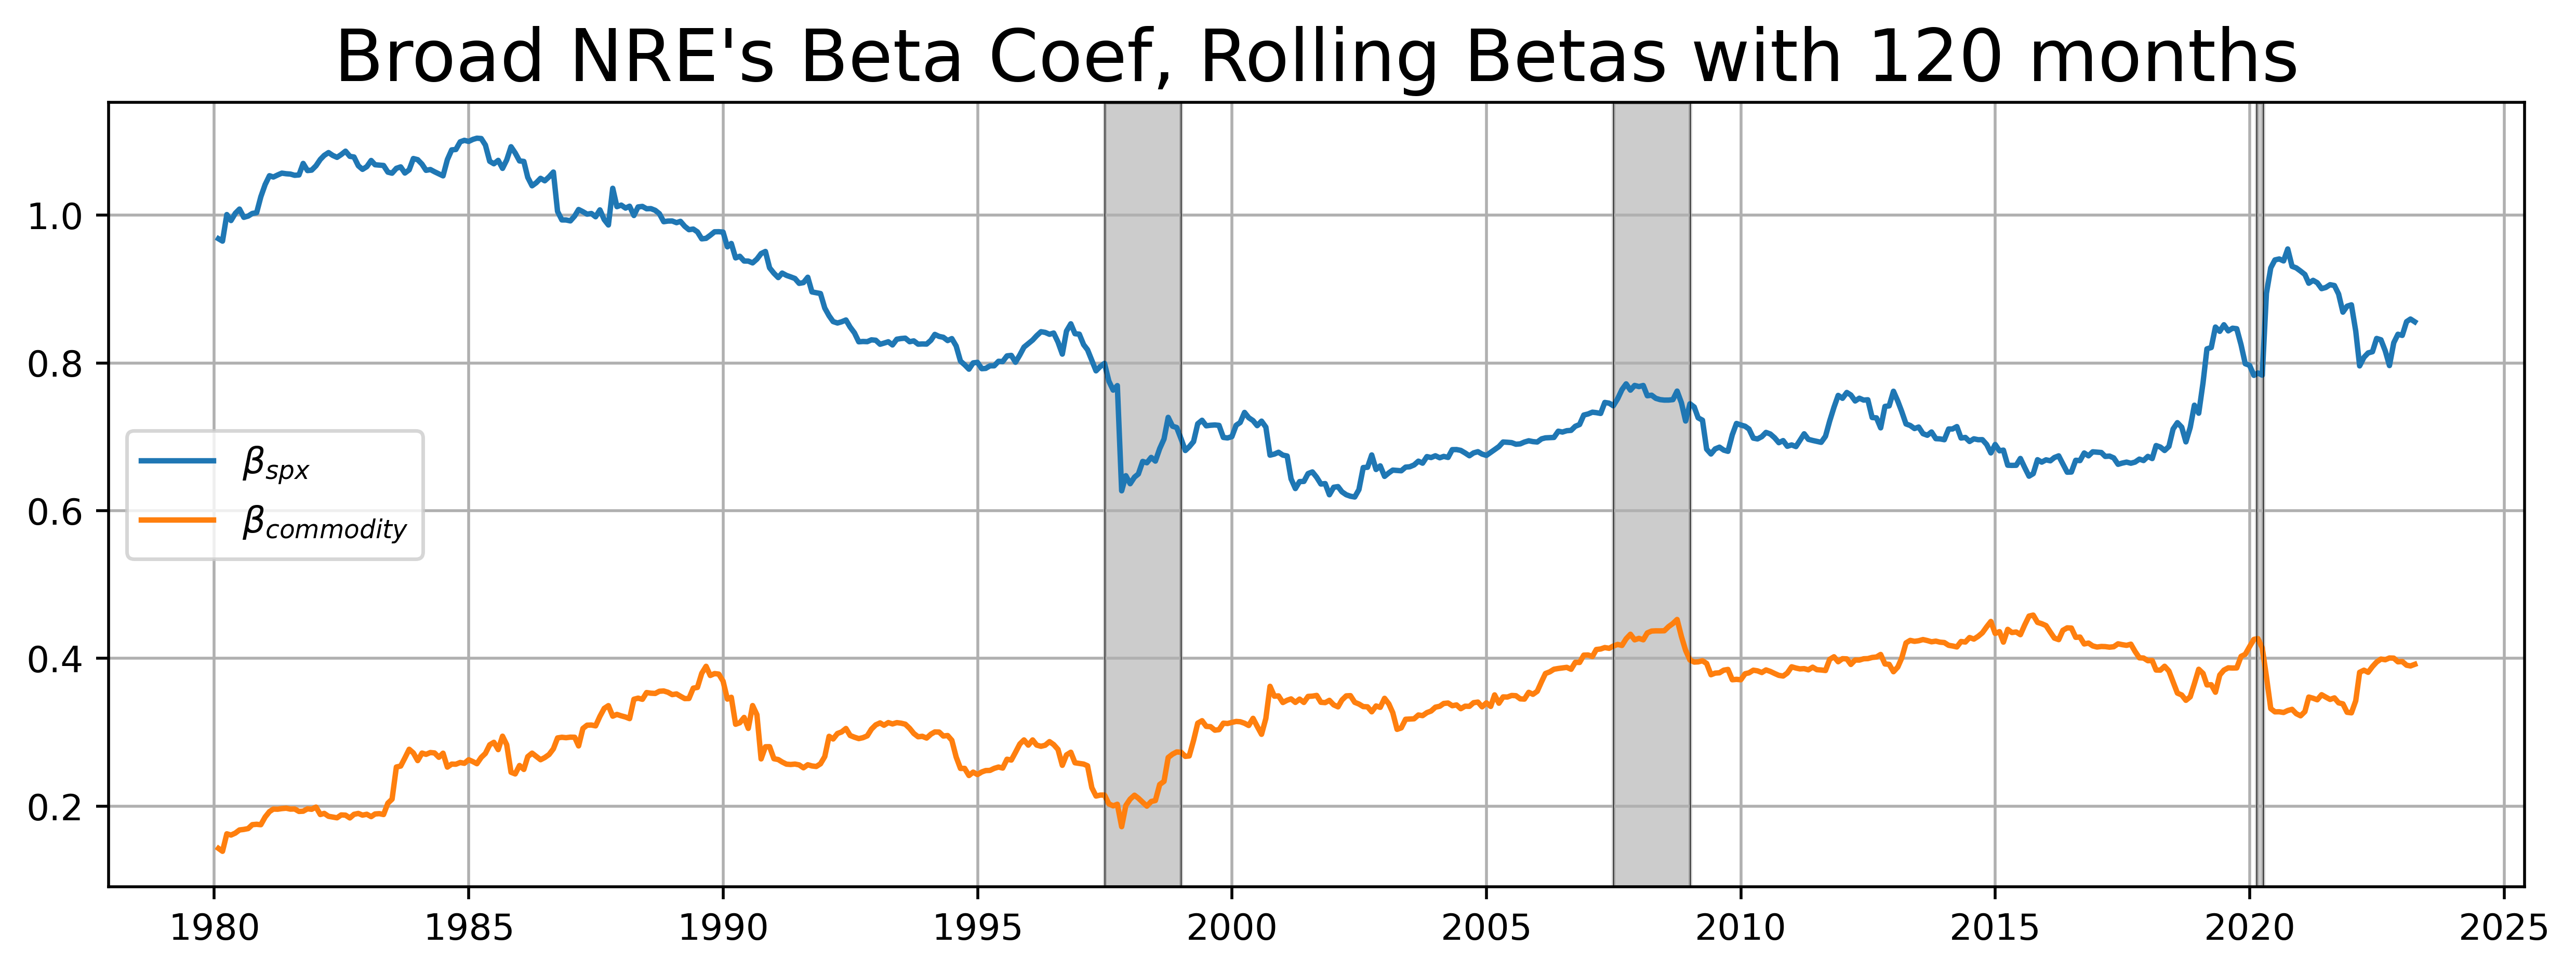

***** Broad NRE STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 11.01%
Broad NRE Volatility : 20.04%
Broad NRE Sharpe : 0.26458


***** Broad Replicate STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 8.53%
Broad NRE Volatility : 16.06%
Broad NRE Sharpe : 0.17595




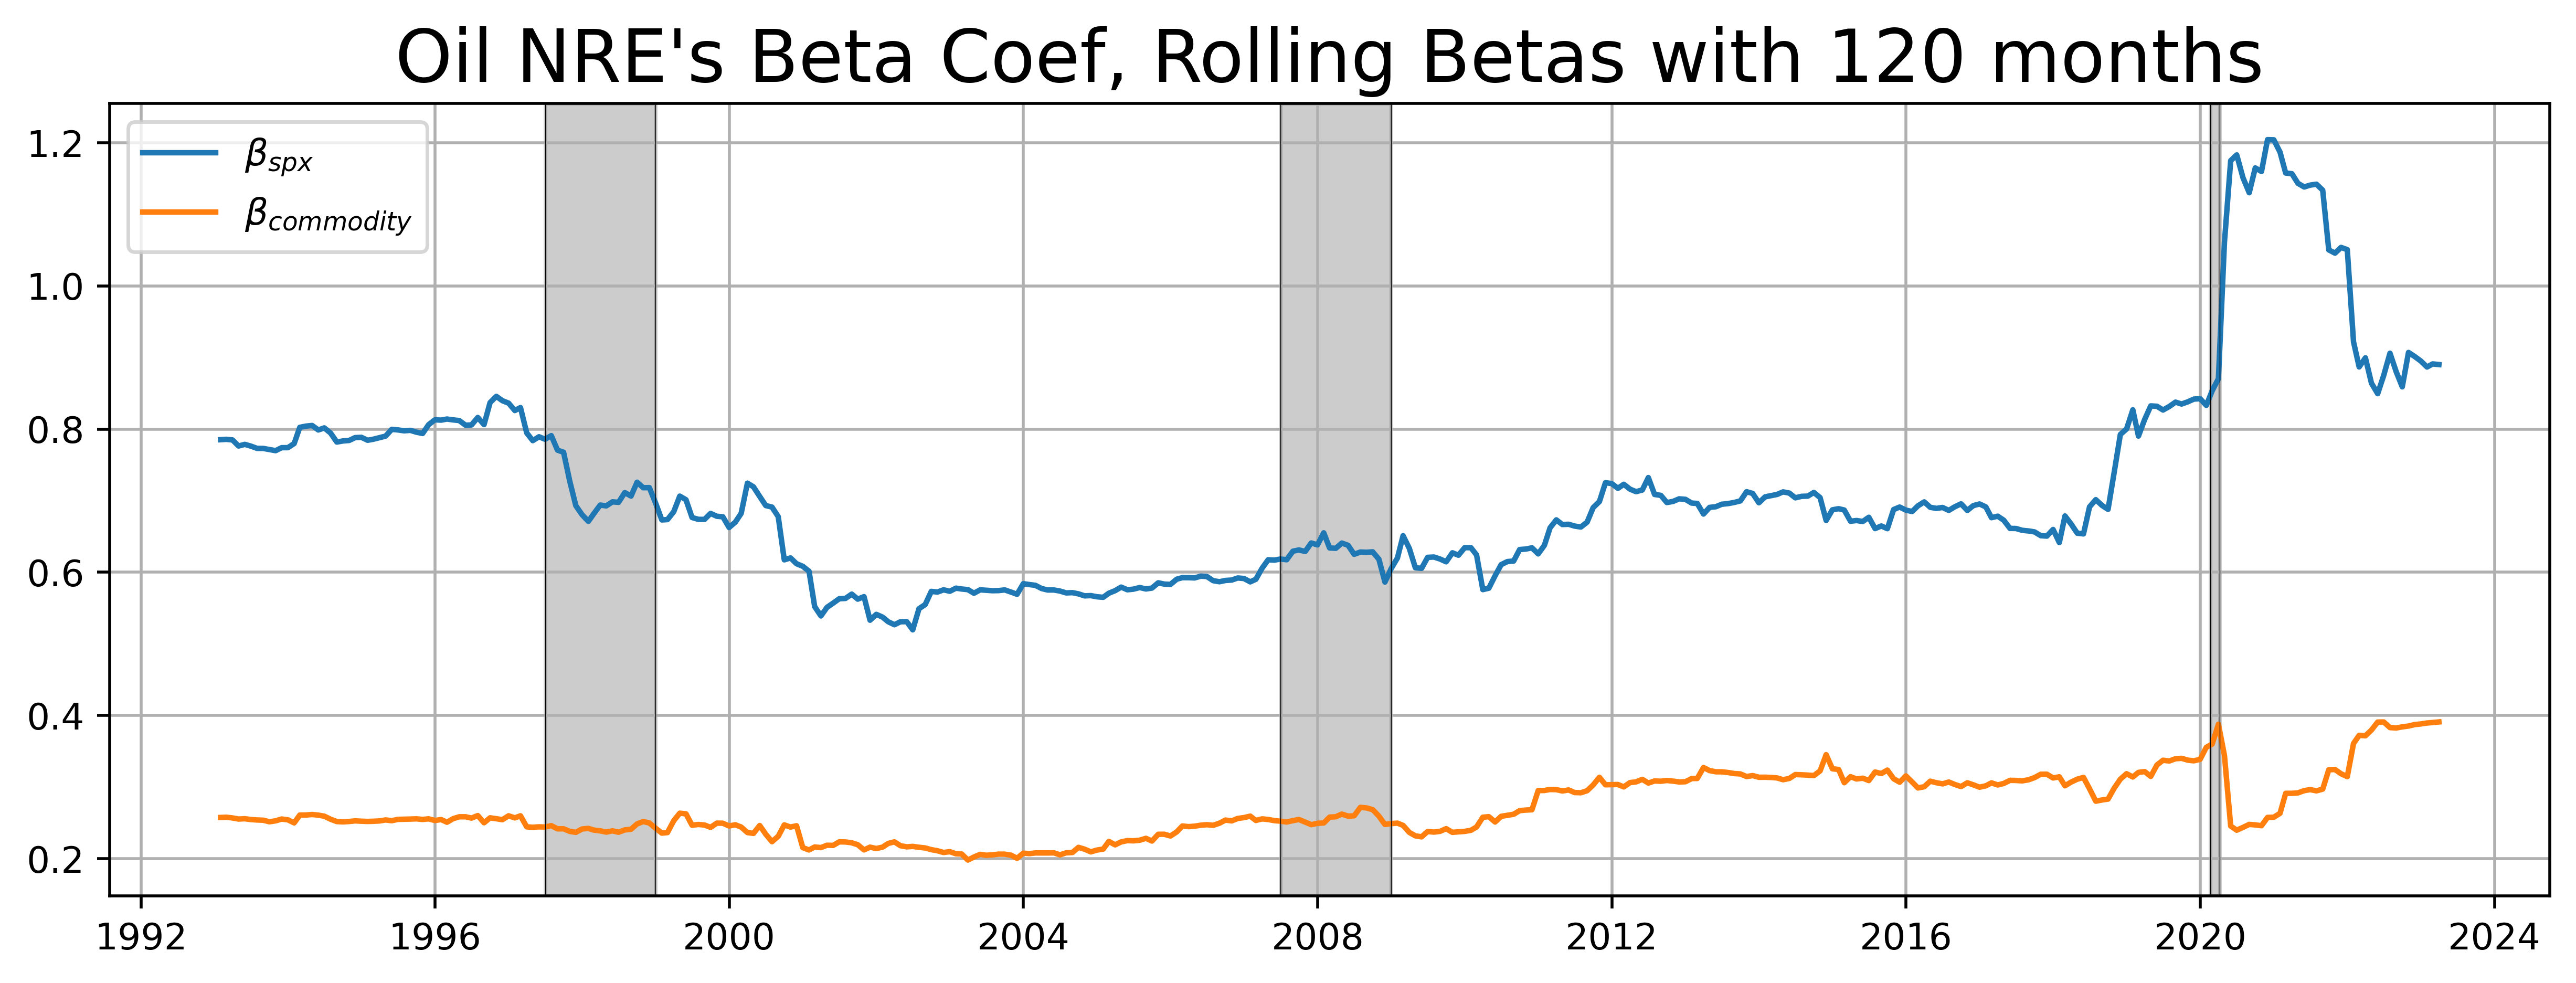

***** Oil NRE STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 12.22%
Broad NRE Volatility : 23.34%
Broad NRE Sharpe : 0.35704


***** Oil Replicate STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 9.34%
Broad NRE Volatility : 16.41%
Broad NRE Sharpe : 0.33278




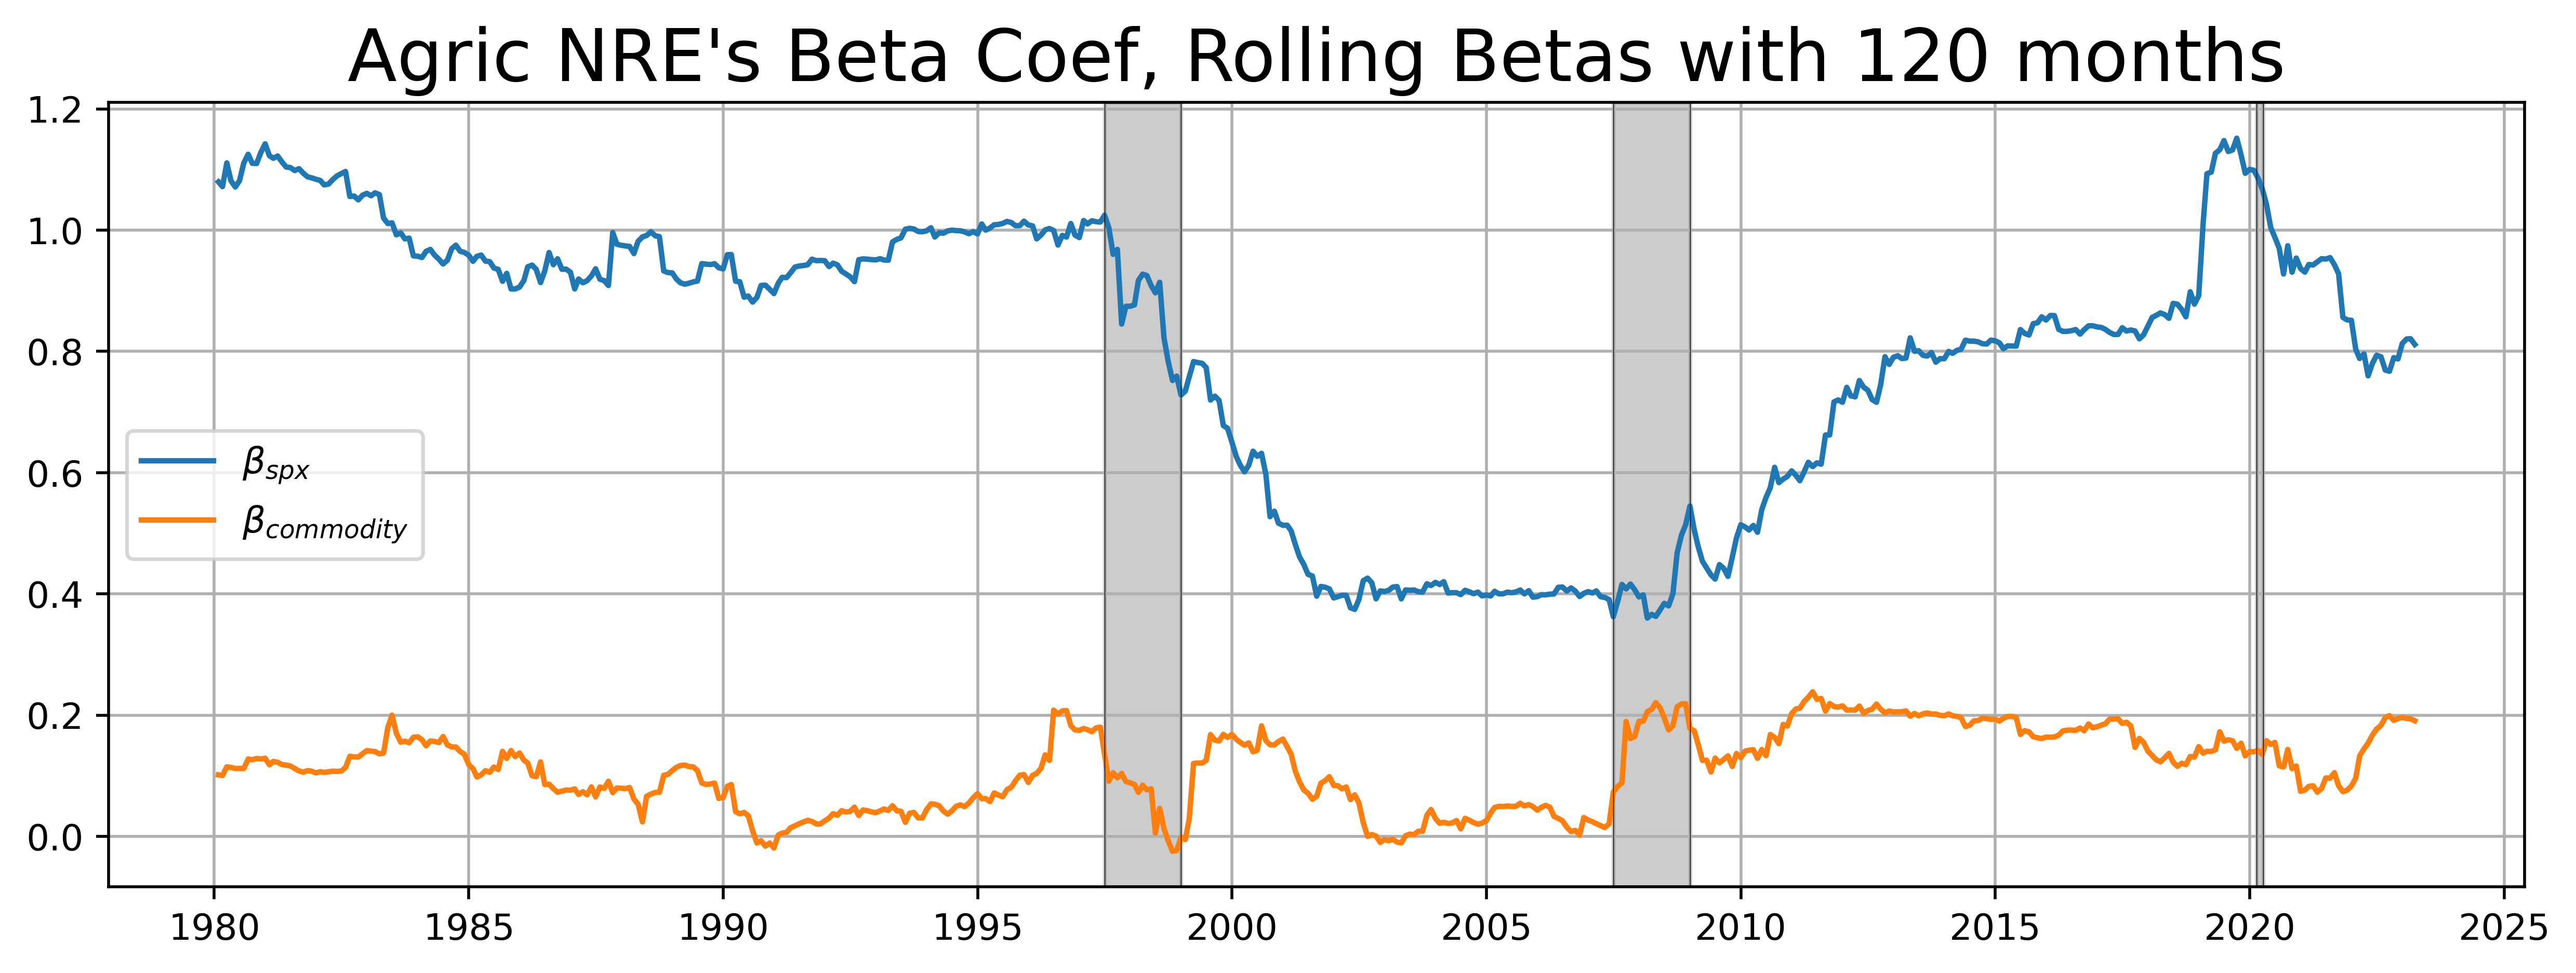

***** Agric NRE STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 13.04%
Broad NRE Volatility : 21.75%
Broad NRE Sharpe : 0.33742


***** Agric Replicate STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 9.01%
Broad NRE Volatility : 13.2%
Broad NRE Sharpe : 0.25049




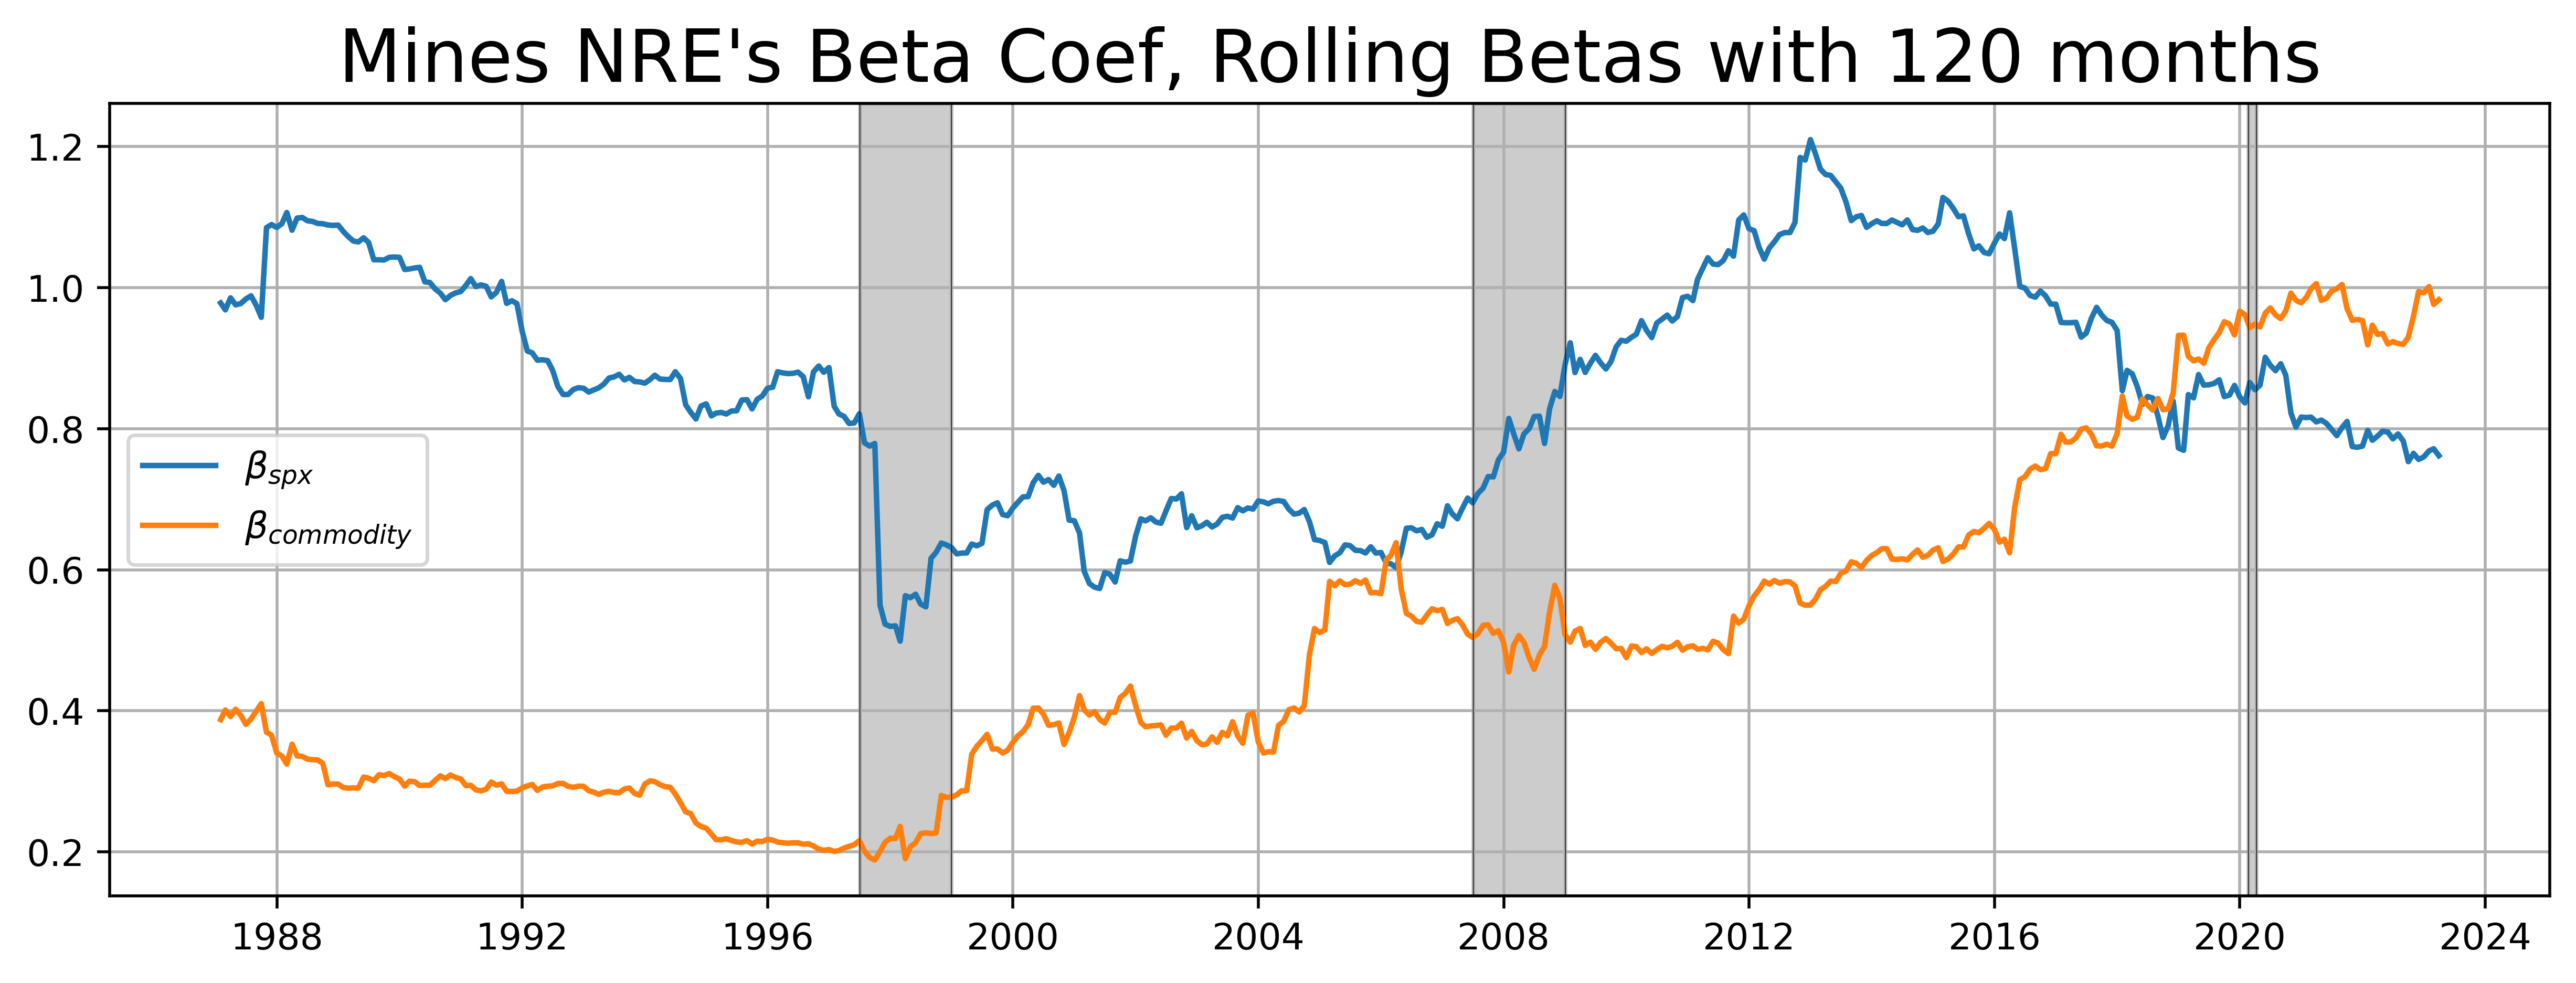

***** Mines NRE STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 14.61%
Broad NRE Volatility : 28.13%
Broad NRE Sharpe : 0.35624


***** Mines Replicate STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 10.25%
Broad NRE Volatility : 20.15%
Broad NRE Sharpe : 0.28072




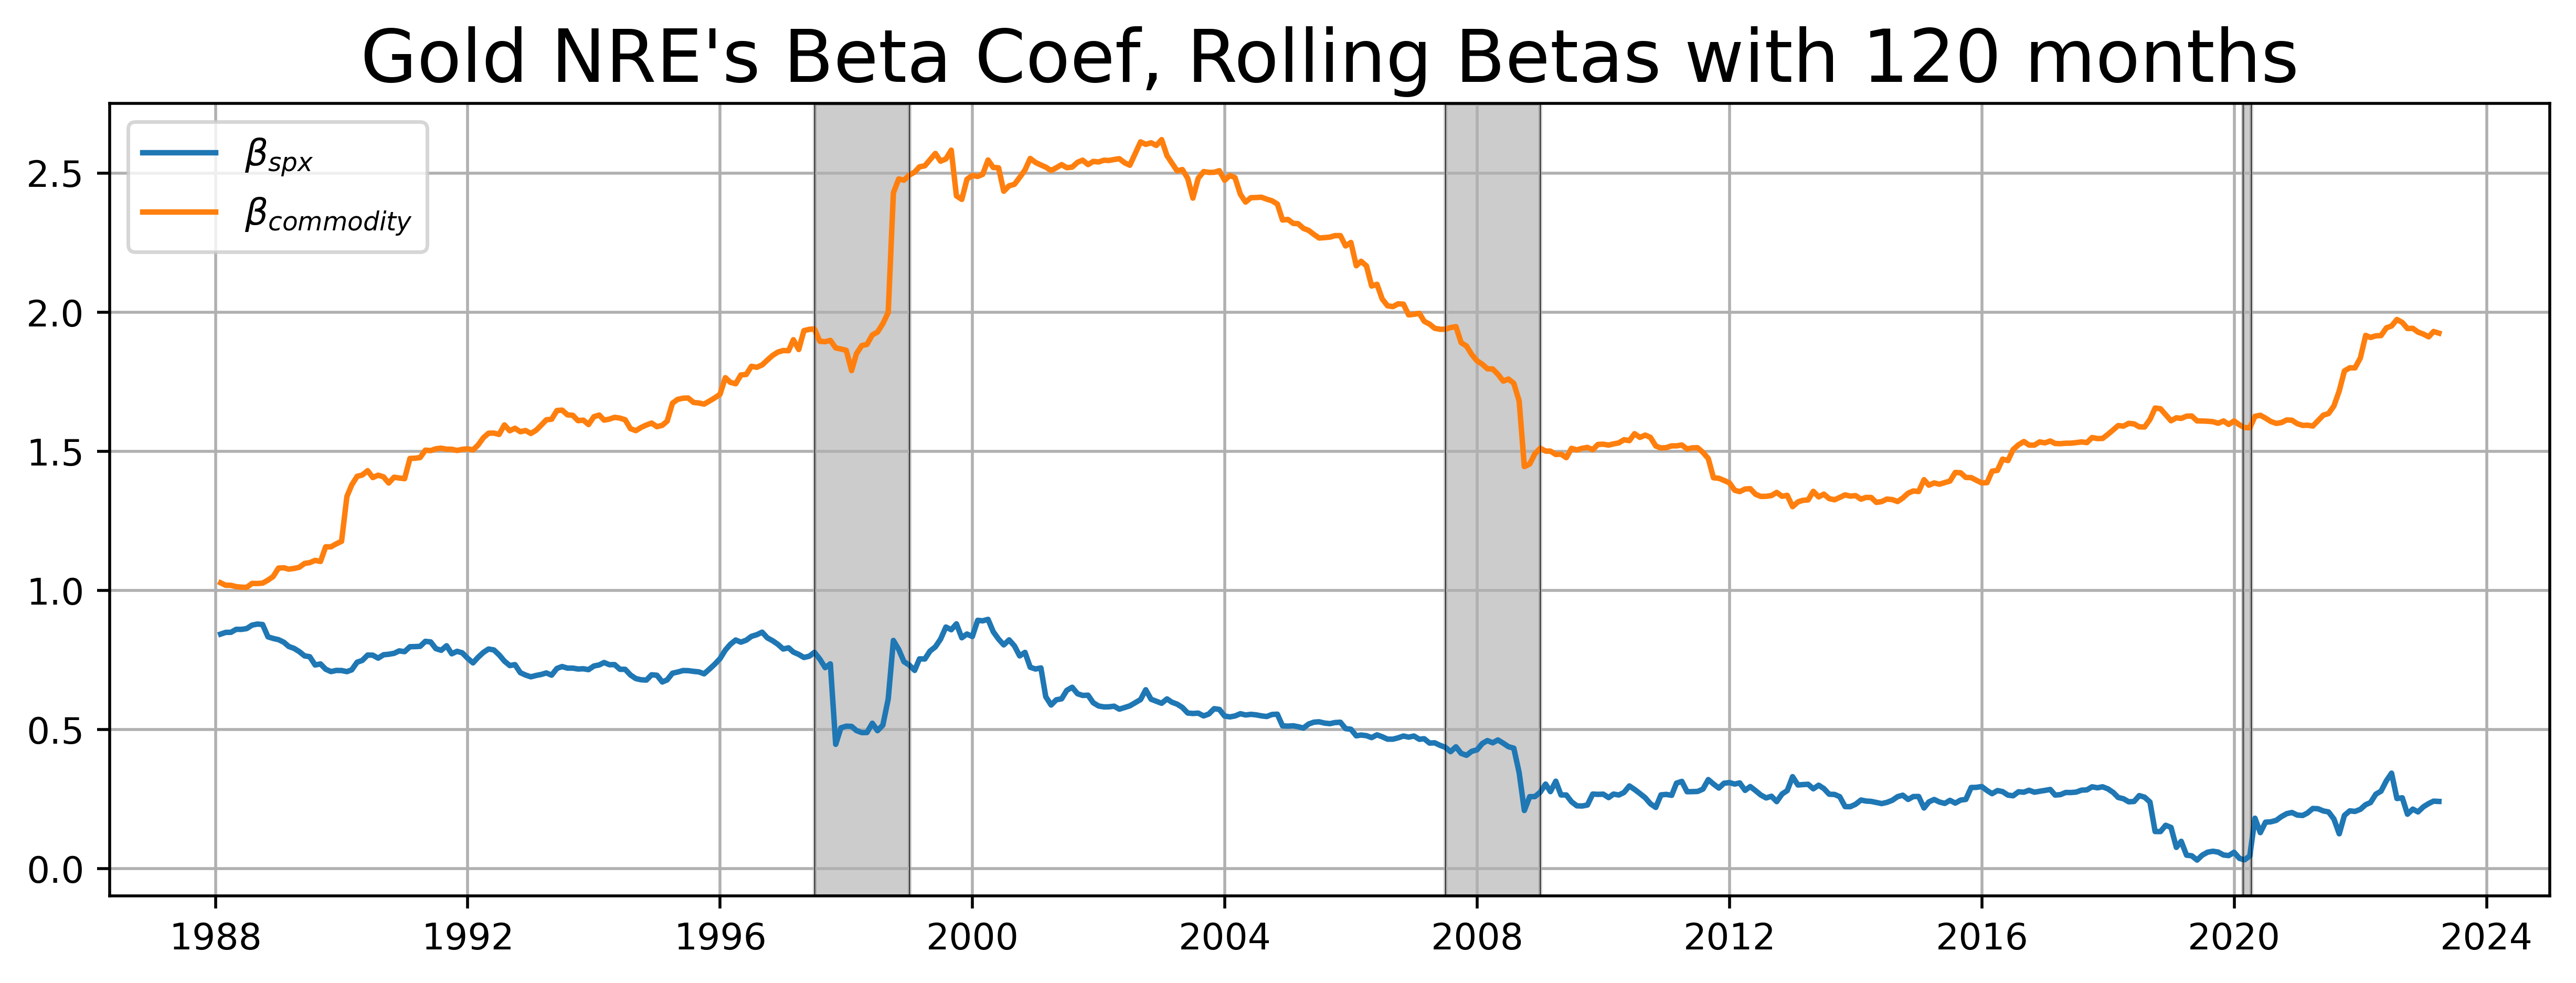

***** Gold NRE STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 7.42%
Broad NRE Volatility : 37.43%
Broad NRE Sharpe : 0.07851


***** Gold Replicate STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 9.61%
Broad NRE Volatility : 27.62%
Broad NRE Sharpe : 0.18554




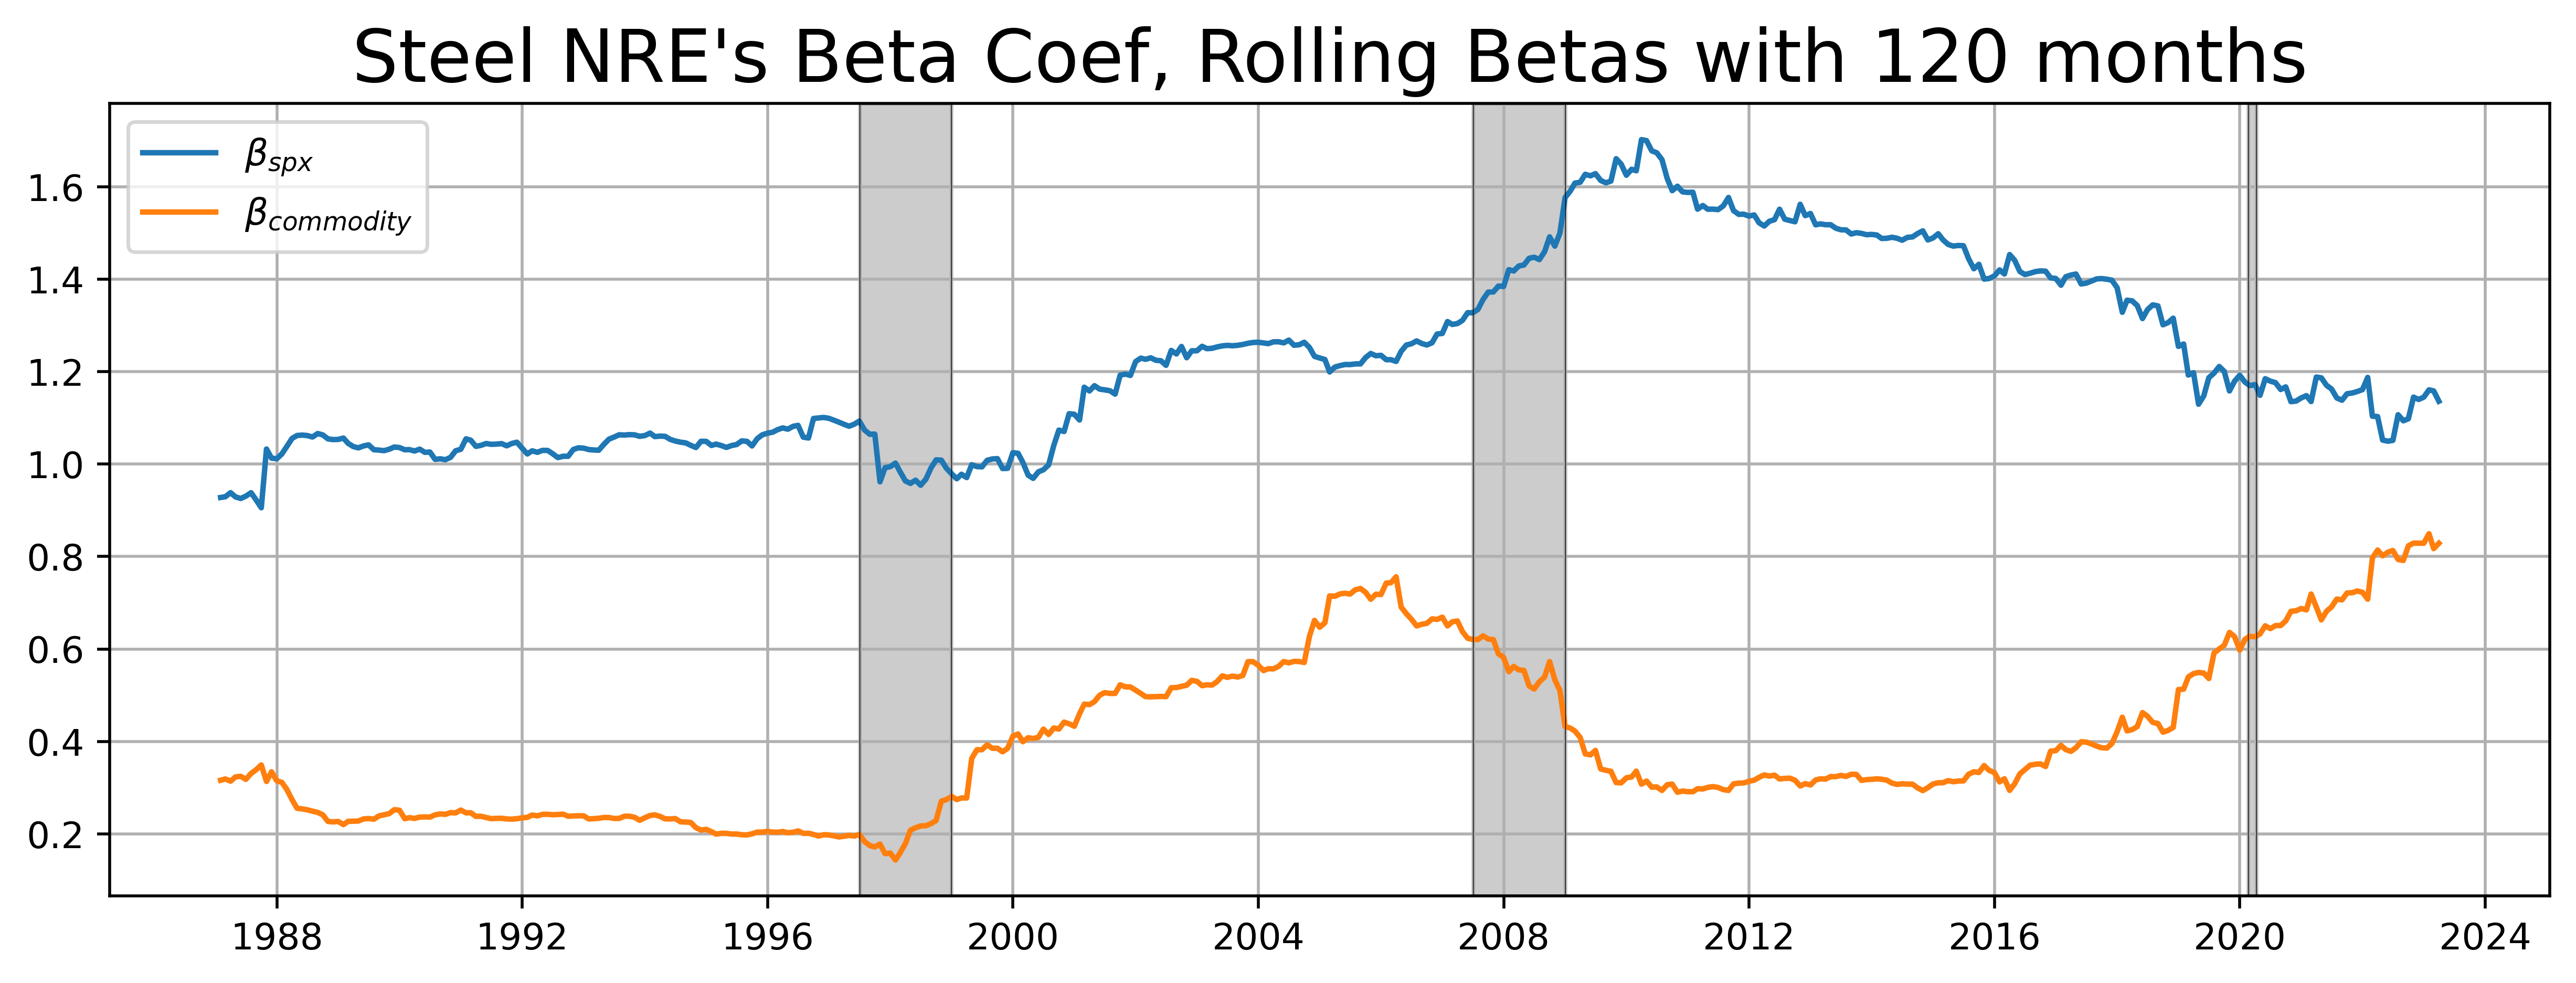

***** Steel NRE STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 11.71%
Broad NRE Volatility : 30.12%
Broad NRE Sharpe : 0.23618


***** Steel Replicate STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 11.39%
Broad NRE Volatility : 24.21%
Broad NRE Sharpe : 0.28089




In [282]:
com_dict = {'Oil' : 'Pet', 'Agric' : 'Agri', 'Mines' : 'Metal', 'Gold' : 'Gold', 'Steel' : 'Metal', 'Broad' : 'Broad'}

mean_beta_data = []
mean_r_data = [] 
total_horizon_data = []
total_returns_data = []
total_vol_data = []
total_sharpe_data = []

sector_list = ['Broad']
[sector_list.append(x) for x in df.columns.to_list()]
sector_list

for sector_name in sector_list:

    sector = sector_name
    com_sector = com_dict[sector]

    if sector_name != 'Broad':
    
        sector_nre = df[[sector]].apply(lambda x: x/100)
    else:
        '''Broad 일 때,'''
        sector_nre = pd.DataFrame(np.diag(df @ df_size.T), index=df_size.index, columns=['Broad']).apply(lambda x:x/100)
        #sector_nre = pd.DataFrame(df.mean(axis=1),columns=['Broad']).apply(lambda x:x/100)

    setup_df = pd.concat([sector_nre, spx.pct_change(), com_df[[com_sector]].pct_change()], axis=1).dropna()

    x = sm.add_constant(setup_df.iloc[:, 1:])
    y = setup_df.iloc[:, [0]]

    sector_beta_fit = RollingOLS(y, x, 120).fit()
    sector_beta_reg = sector_beta_fit.params.dropna().iloc[:, 1:]

    plt.figure(figsize=(12, 4), dpi=500)
    plt.title(f"{sector_name} NRE's Beta Coef, Rolling Betas with 120 months", size=20)
    # plt.plot(reg.params['SPX'].loc[:'2015'].dropna(), label=r'$\beta_{spx}$')
    # plt.plot(reg.params['Broad'].loc[:'2015'].dropna(), label=r'$\beta_{commodity}$')

    plt.plot(sector_beta_reg.iloc[:, 0], label=r'$\beta_{spx}$')
    plt.plot(sector_beta_reg.iloc[:, 1], label=r'$\beta_{commodity}$')

    #plotting_crisis('1987-10-19', '1987-10-24') # black monday
    #plotting_crisis('1995-01-01', '2001-12-31') # Dotcom Bubble
    plotting_crisis('1997-07-01', '1998-12-31') # Asian Financial Crisis
    plotting_crisis('2007-07-01', '2008-12-31') # Subprime Mortgage Crisis
    #plotting_crisis('2009-10-01', '2011-04-30') # Euro-zone Default Risk
    plotting_crisis('2020-02-20', '2020-04-07') # Covid-19


    
    plt.grid()
    plt.legend()
    plt.show()


    mean_beta = pd.DataFrame(sector_beta_fit.params.dropna().mean().iloc[1:], columns=[sector])
    mean_beta.index = ['Equity_Beta', 'Commodity_Beta']
    mean_beta_data.append(mean_beta)

    mean_r = pd.DataFrame([sector_beta_fit.rsquared.dropna().mean()], columns=[sector], index=['R^2'])
    mean_r_data.append(mean_r)

    total_horizon = str(sector_beta_reg.iloc[0].name)[0:10] + ' ~ ' + str(sector_beta_reg.iloc[-1].name)[0:10]
    total_horizon_data.append(total_horizon)

    '''투자비중 설정'''
    sector_beta_reg['cash'] = sector_beta_reg.apply(lambda x : (1-x.iloc[0]-x.iloc[1]), axis=1).copy()
    ret_df = pd.concat([spx.pct_change(), com_df[[com_sector]].pct_change(), rf.apply(lambda x: x/100)], axis=1).dropna().shift(-1).loc[sector_beta_reg.index]

    '''rf 수익률 사용할 때 1달 투자니 x/12로 해야함'''
    ret_df.rf = ret_df.rf.apply(lambda x: x/12)

    '''Replicate Port 수익률'''
    sector_pnl = pd.DataFrame(np.diag(ret_df @ sector_beta_reg.values.T), columns=['pnl'], index=ret_df.index)

    '''nre period all : 1980-01-31 ~ 2023-03-31'''
    sector_nre_returns = (sector_nre.loc[sector_pnl.index].mean() * 12 * 100).item()
    sector_nre_vol = np.sqrt(sector_nre.loc[sector_pnl.index].var() * 12).item() * 100
    sector_nre_sharpe = ((sector_nre.loc[sector_pnl.index] - rf.loc[sector_pnl.index].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / sector_nre_vol

    print(f'***** {sector} NRE STATS (1980-01-31 ~ 2023-03-31) *****')
    print(f'Broad NRE Performance : {np.round(sector_nre_returns, 2)}%')
    print(f'Broad NRE Volatility : {np.round(sector_nre_vol, 2)}%')
    print(f'Broad NRE Sharpe : {np.round(sector_nre_sharpe, 5)}')
    print('\n')

    '''nre period all : 1980-01-31 ~ 2023-03-31'''
    sector_pnl_returns = (sector_pnl.mean() * 12 * 100).item()
    sector_pnl_vol = np.sqrt(sector_pnl.var() * 12).item() * 100
    sector_pnl_sharpe = ((sector_pnl - rf.loc[sector_pnl.index].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / sector_pnl_vol

    print(f'***** {sector} Replicate STATS (1980-01-31 ~ 2023-03-31) *****')
    print(f'Broad NRE Performance : {np.round(sector_pnl_returns, 2)}%')
    print(f'Broad NRE Volatility : {np.round(sector_pnl_vol, 2)}%')
    print(f'Broad NRE Sharpe : {np.round(sector_pnl_sharpe, 5)}')
    print('\n')

    total_returns_data.append(pd.DataFrame([sector_nre_returns, sector_pnl_returns], index=['NRE', 'Replicate'], columns=['Returns(%)']))
    total_vol_data.append(pd.DataFrame([sector_nre_vol, sector_pnl_vol], index=['NRE', 'Replicate'], columns=['Volatility(%)']))
    total_sharpe_data.append(pd.DataFrame([sector_nre_sharpe, sector_pnl_sharpe], index=['NRE', 'Replicate'], columns=['Sharpe']))


        

In [22]:
# mean_beta_data = []
# mean_r_data = [] 
# total_horizon_data = []
# total_returns_data = []
# total_vol_data = []
# total_sharpe_data = []

In [235]:
mean_beta_df = pd.DataFrame(pd.concat(mean_beta_data,axis=1).T).apply(lambda x: np.round(x,2))
mean_beta_df

Equity_Beta  Commodity_Beta
Broad         0.82            0.33
Oil           0.71            0.27
Agric         0.80            0.11
Mines         0.86            0.50
Gold          0.49            1.76
Steel         1.23            0.40

In [274]:
pd.concat(mean_r_data, axis=1).apply(lambda x : np.round(x, 2)*100 ) 

Broad   Oil  Agric  Mines  Gold  Steel
R^2   63.0  56.0   36.0   50.0  53.0   66.0

In [285]:
aa = pd.concat([pd.concat(total_returns_data), pd.concat(total_vol_data), pd.concat(total_sharpe_data)], axis=1).T.apply(lambda x: np.round(x,2))
aa.columns = pd.MultiIndex.from_tuples([(str(x+f' ({str(total_horizon_data[i])})'),y) for i, x in enumerate(sector_list) for y in ['NRE', 'Replicate']])
#aa.columns = pd.MultiIndex.from_tuples([(str(x),y) for x in sector_list for y in ['NRE', 'Replicate']])
aa

Broad (1980-01-31 ~ 2023-03-31)            \
                                          NRE Replicate   
Returns(%)                              11.01      8.53   
Volatility(%)                           20.04     16.06   
Sharpe                                   0.26      0.18   

              Oil (1993-01-31 ~ 2023-03-31)            \
                                        NRE Replicate   
Returns(%)                            12.22      9.34   
Volatility(%)                         23.34     16.41   
Sharpe                                 0.36      0.33   

              Agric (1980-01-31 ~ 2023-03-31)            \
                                          NRE Replicate   
Returns(%)                              13.04      9.01   
Volatility(%)                           21.75     13.20   
Sharpe                                   0.34      0.25   

              Mines (1987-01-31 ~ 2023-03-31)            \
                                          NRE Replicate   
Returns(%)                              14.61     10.25   
Volatility(%)                           28.13     20.15   
Sharpe                                   0.36      0.28   

              Gold (1988-01-31 ~ 2023-03-31)            \
                                         NRE Replicate   
Returns(%)                              7.42      9.61   
Volatility(%)                          37.43     27.62   
Sharpe                                  0.08      0.19   

              Steel (1987-01-31 ~ 2023-03-31)            
                                          NRE Replicate  
Returns(%)                              11.71     11.39  
Volatility(%)                           30.12     24.21  
Sharpe                                   0.24      0.28

In [237]:
mean_beta_df.to_csv('./pics/mean_beta.csv')

In [261]:
mean_beta_df.stack().unstack().sort_index(ascending=False)

Beta               
       Equity_Beta Commodity_Beta
Sector                           
Steel     1.226511       0.403484
Oil       0.713068       0.270936
Mines     0.859464       0.498069
Gold      0.489586       1.762157
Broad     0.817660       0.328540
Agric     0.798545       0.112068

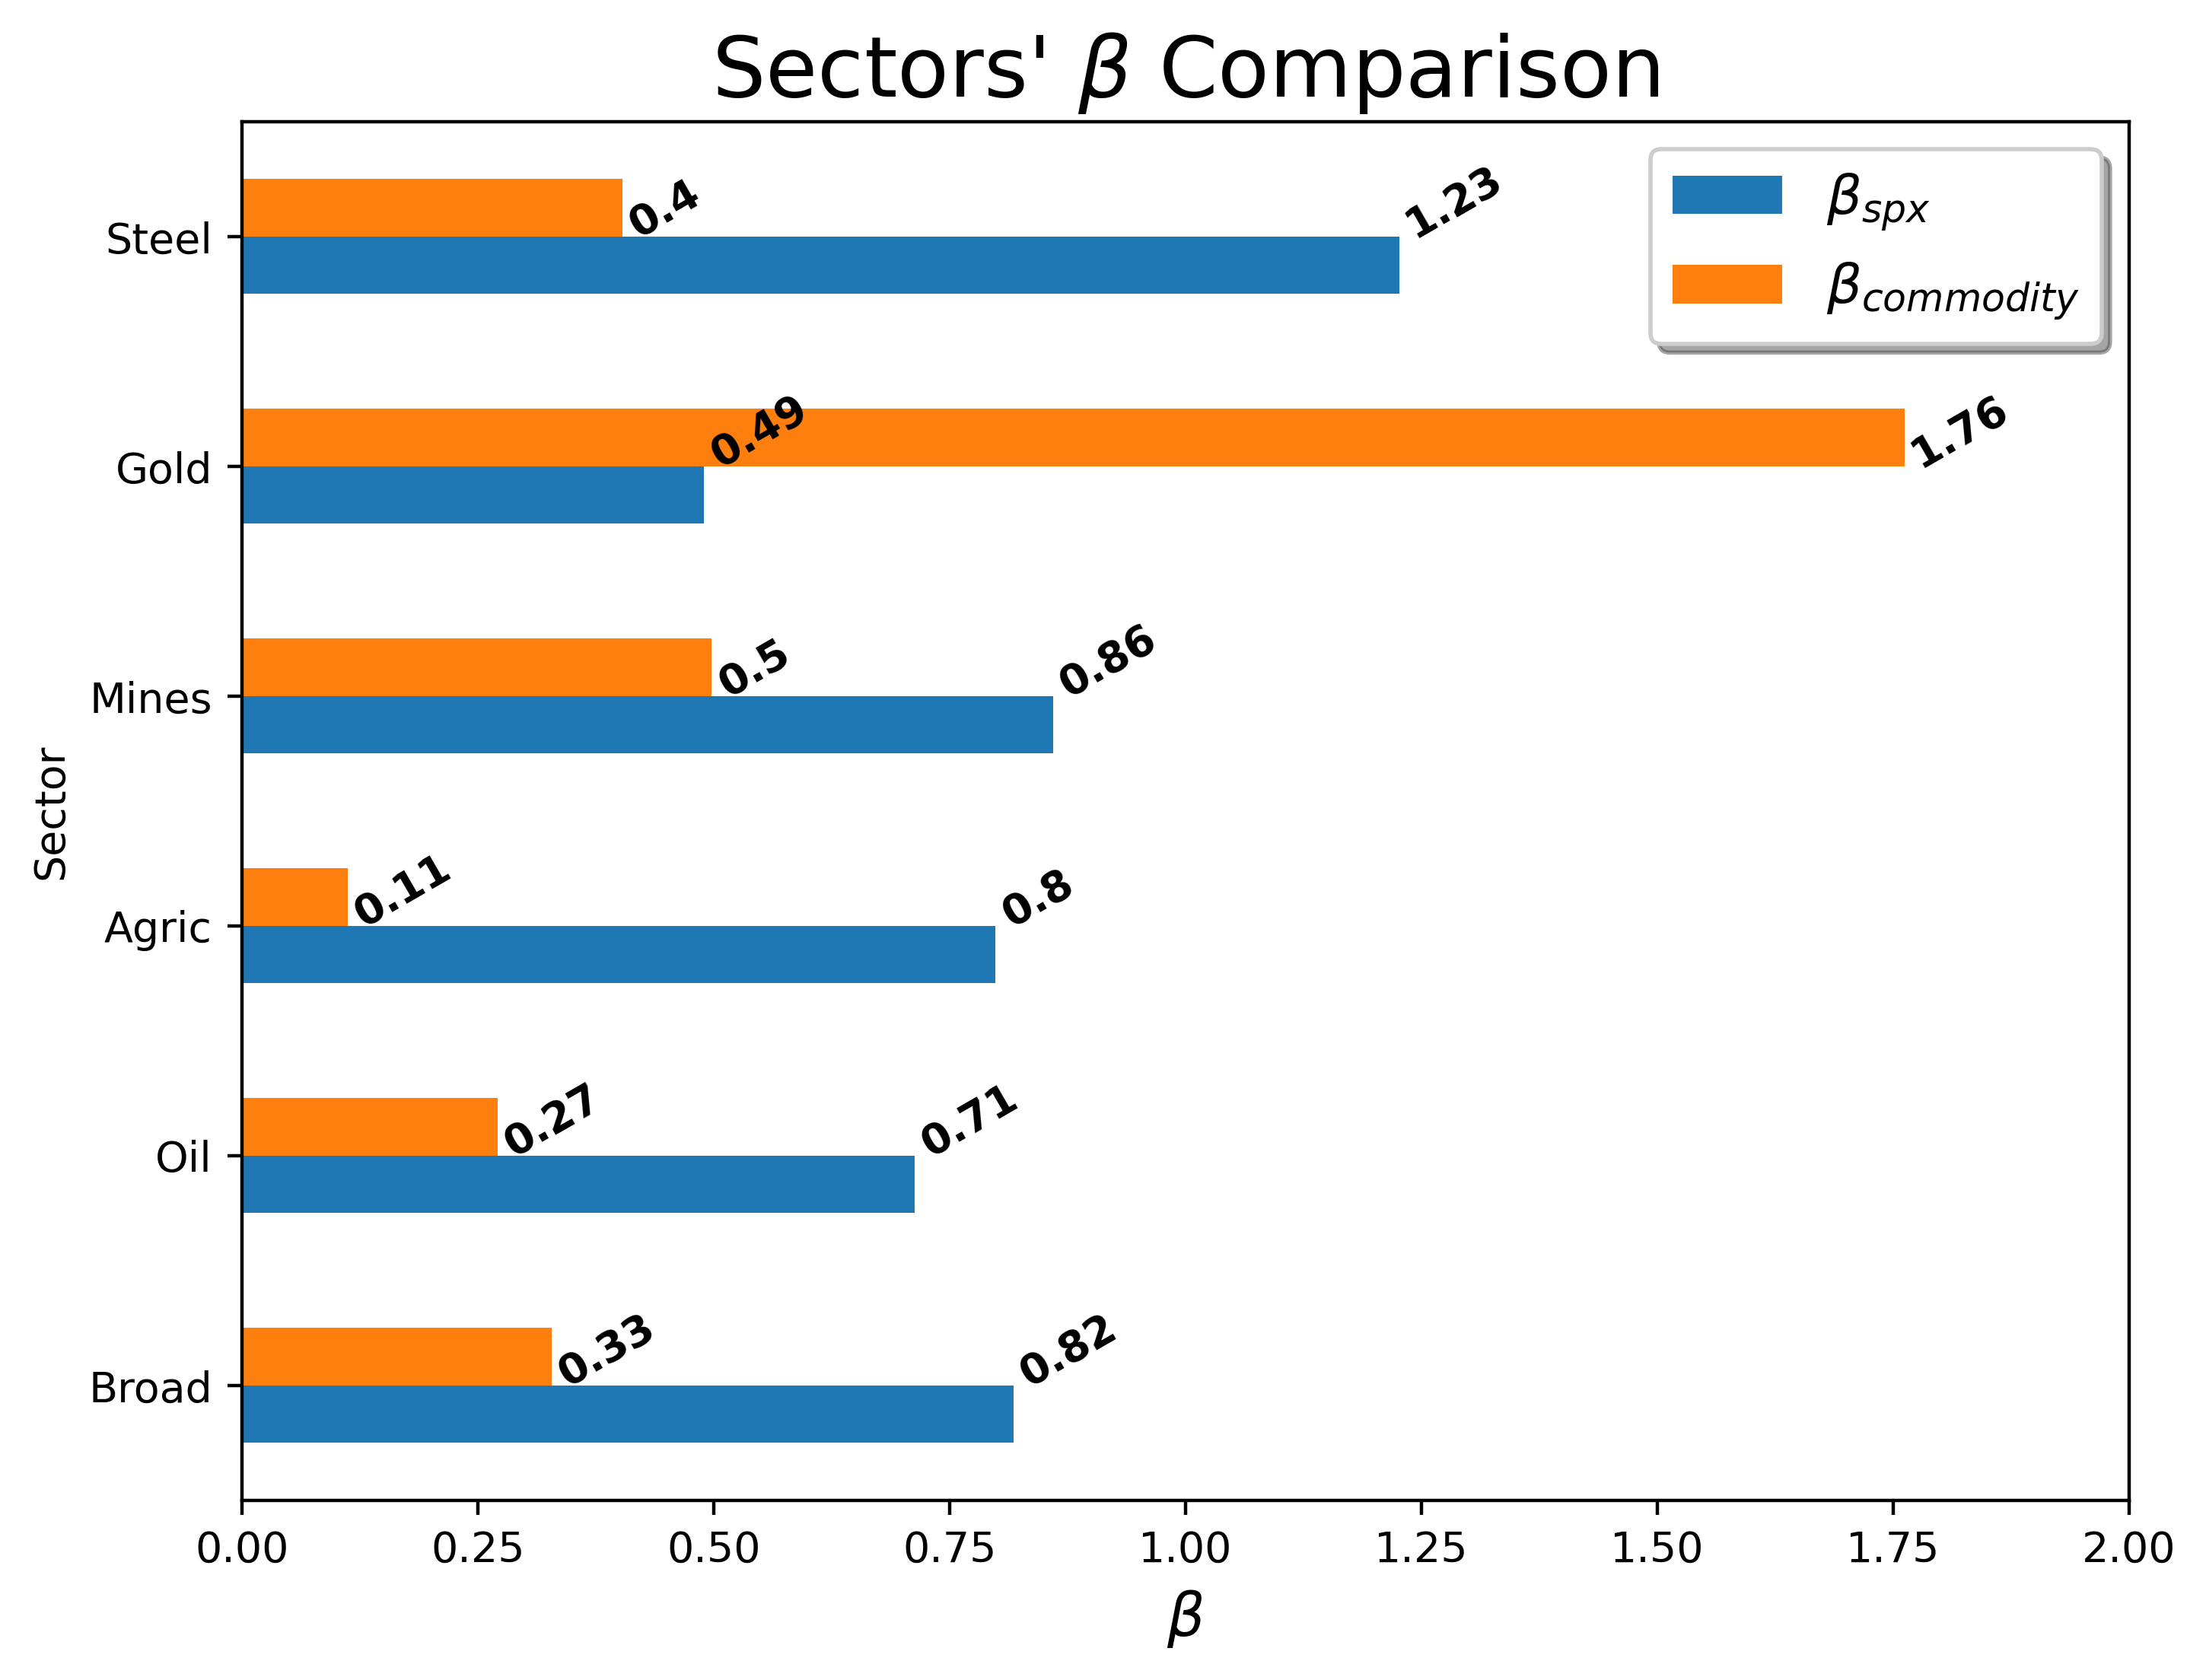

In [269]:
mean_beta_df = pd.DataFrame(pd.concat(mean_beta_data,axis=1).T)
mean_beta_df.index.name = 'Sector'
mean_beta_df = pd.DataFrame(mean_beta_df.stack(), columns=['Beta']).unstack()


fig = plt.figure(dpi=400)
ax = mean_beta_df.plot.barh(figsize=(8,6), ax=plt.gca())

for i, row in enumerate(mean_beta_df.itertuples()):
    for j, value in enumerate(row[1:]):
        ax.text(value, i, str(np.round(value,2)), ha='left', va='baseline', weight='bold', rotation=30)
        
plt.title(r"Sectors' $\beta$ Comparison", size=20)
plt.xlabel(r'$\beta$', size=14)
plt.ylabel('Sector')
plt.legend([r'$\beta_{spx}$', r'$\beta_{commodity}$'], loc='best',fontsize=13, frameon=True, shadow=True)
plt.xlim(0, 2)
plt.show()

## 최근 10년

In [286]:
com_dict = {'Oil' : 'Pet', 'Agric' : 'Agri', 'Mines' : 'Metal', 'Gold' : 'Gold', 'Steel' : 'Metal', 'Broad' : 'Broad'}

mean_beta_data = []
mean_r_data = [] 
total_horizon_data = []
total_returns_data = []
total_vol_data = []
total_sharpe_data = []

sector_list = ['Broad']
[sector_list.append(x) for x in df.columns.to_list()]
sector_list

for sector_name in sector_list:

    sector = sector_name
    com_sector = com_dict[sector]

    if sector_name != 'Broad':
    
        sector_nre = df[[sector]].apply(lambda x: x/100)
    else:
        '''Broad 일 때,'''
        sector_nre = pd.DataFrame(np.diag(df @ df_size.T), index=df_size.index, columns=['Broad']).apply(lambda x:x/100)

    setup_df = pd.concat([sector_nre, spx.pct_change(), com_df[[com_sector]].pct_change()], axis=1).dropna()

    x = sm.add_constant(setup_df.iloc[:, 1:])
    y = setup_df.iloc[:, [0]]

    sector_beta_fit = RollingOLS(y, x, 120).fit()
    sector_beta_reg = sector_beta_fit.params.dropna().iloc[:, 1:]

    mean_beta = pd.DataFrame(sector_beta_fit.params.dropna().mean().iloc[1:], columns=[sector])
    mean_beta.index = ['Equity_Beta', 'Commodity_Beta']
    mean_beta_data.append(mean_beta)

    mean_r = pd.DataFrame([sector_beta_fit.rsquared.dropna().mean()], columns=[sector], index=['R^2'])
    mean_r_data.append(mean_r)

    total_horizon = str(sector_beta_reg.iloc[0].name)[0:10] + ' ~ ' + str(sector_beta_reg.iloc[-1].name)[0:10]
    total_horizon_data.append(total_horizon)

    '''투자비중 설정'''
    sector_beta_reg['cash'] = sector_beta_reg.apply(lambda x : (1-x.iloc[0]-x.iloc[1]), axis=1).copy()
    ret_df = pd.concat([spx.pct_change(), com_df[[com_sector]].pct_change(), rf.apply(lambda x: x/100)], axis=1).dropna().shift(-1).loc[sector_beta_reg.index]

    '''rf 수익률 사용할 때 1달 투자니 x/12로 해야함'''
    ret_df.rf = ret_df.rf.apply(lambda x: x/12)

    '''Replicate Port 수익률'''
    sector_pnl = pd.DataFrame(np.diag(ret_df @ sector_beta_reg.values.T), columns=['pnl'], index=ret_df.index)

    '''nre period all : 2013-03-31 ~ 2023-03-31'''
    sector_nre_returns = (sector_nre.loc['2013-03-31':].mean() * 12 * 100).item()
    sector_nre_vol = np.sqrt(sector_nre.loc['2013-03-31':].var() * 12).item() * 100
    sector_nre_sharpe = ((sector_nre.loc['2013-03-31':] - rf.loc['2013-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / sector_nre_vol

    print(f'***** {sector} NRE STATS (2013-03-31 ~ 2023-03-31) *****')
    print(f'Broad NRE Performance : {np.round(sector_nre_returns, 2)}%')
    print(f'Broad NRE Volatility : {np.round(sector_nre_vol, 2)}%')
    print(f'Broad NRE Sharpe : {np.round(sector_nre_sharpe, 5)}')
    print('\n')

    '''nre period all : 2013-03-31 ~ 2023-03-31'''
    sector_pnl_returns = (sector_pnl.loc['2013-03-31':].mean() * 12 * 100).item()
    sector_pnl_vol = np.sqrt(sector_pnl.loc['2013-03-31':].var() * 12).item() * 100
    sector_pnl_sharpe = ((sector_pnl.loc['2013-03-31':] - rf.loc['2013-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / sector_pnl_vol

    print(f'***** {sector} Replicate STATS (2013-03-31 ~ 2023-03-31) *****')
    print(f'Broad NRE Performance : {np.round(sector_pnl_returns, 2)}%')
    print(f'Broad NRE Volatility : {np.round(sector_pnl_vol, 2)}%')
    print(f'Broad NRE Sharpe : {np.round(sector_pnl_sharpe, 5)}')
    print('\n')

    total_returns_data.append(pd.DataFrame([sector_nre_returns, sector_pnl_returns], index=['NRE', 'Replicate'], columns=['Returns(%)']))
    total_vol_data.append(pd.DataFrame([sector_nre_vol, sector_pnl_vol], index=['NRE', 'Replicate'], columns=['Volatility(%)']))
    total_sharpe_data.append(pd.DataFrame([sector_nre_sharpe, sector_pnl_sharpe], index=['NRE', 'Replicate'], columns=['Sharpe']))


        

***** Broad NRE STATS (2013-03-31 ~ 2023-03-31) *****
Broad NRE Performance : 8.78%
Broad NRE Volatility : 21.71%
Broad NRE Sharpe : 0.3041


***** Broad Replicate STATS (2013-03-31 ~ 2023-03-31) *****
Broad NRE Performance : 7.82%
Broad NRE Volatility : 17.62%
Broad NRE Sharpe : 0.32041


***** Oil NRE STATS (2013-03-31 ~ 2023-03-31) *****
Broad NRE Performance : 9.29%
Broad NRE Volatility : 30.23%
Broad NRE Sharpe : 0.23542


***** Oil Replicate STATS (2013-03-31 ~ 2023-03-31) *****
Broad NRE Performance : 10.04%
Broad NRE Volatility : 21.07%
Broad NRE Sharpe : 0.37312


***** Agric NRE STATS (2013-03-31 ~ 2023-03-31) *****
Broad NRE Performance : 10.86%
Broad NRE Volatility : 20.34%
Broad NRE Sharpe : 0.42654


***** Agric Replicate STATS (2013-03-31 ~ 2023-03-31) *****
Broad NRE Performance : 9.56%
Broad NRE Volatility : 14.06%
Broad NRE Sharpe : 0.5246


***** Mines NRE STATS (2013-03-31 ~ 2023-03-31) *****
Broad NRE Performance : 11.38%
Broad NRE Volatility : 28.54%
Broad NRE Sha

In [287]:
aa = pd.concat([pd.concat(total_returns_data), pd.concat(total_vol_data), pd.concat(total_sharpe_data)], axis=1).T.apply(lambda x: np.round(x,2))
aa.columns = pd.MultiIndex.from_tuples([(str(x+f' (recent 10 years)'),y) for x in sector_list for y in ['NRE', 'Replicate']])
aa

Broad (recent 10 years)           Oil (recent 10 years)  \
                                  NRE Replicate                   NRE   
Returns(%)                       8.78      7.82                  9.29   
Volatility(%)                   21.71     17.62                 30.23   
Sharpe                           0.30      0.32                  0.24   

                        Agric (recent 10 years)            \
              Replicate                     NRE Replicate   
Returns(%)        10.04                   10.86      9.56   
Volatility(%)     21.07                   20.34     14.06   
Sharpe             0.37                    0.43      0.52   

              Mines (recent 10 years)           Gold (recent 10 years)  \
                                  NRE Replicate                    NRE   
Returns(%)                      11.38     12.29                   8.76   
Volatility(%)                   28.54     23.53                  38.14   
Sharpe                           0.32      0.43                   0.17   

                        Steel (recent 10 years)            
              Replicate                     NRE Replicate  
Returns(%)         6.83                   15.42     14.79  
Volatility(%)     23.38                   32.38     24.58  
Sharpe             0.20                    0.41      0.51

# 개별 확인 및 개선

In [30]:
sector_list[0:1]

['Broad']

In [162]:
com_dict = {'Oil' : 'Pet', 'Agric' : 'Agri', 'Mines' : 'Metal', 'Gold' : 'Gold', 'Steel' : 'Metal', 'Broad' : 'Broad'}

mean_beta_data = []
mean_r_data = [] 
total_horizon_data = []
total_returns_data = []
total_vol_data = []
total_sharpe_data = []

sector_list = ['Broad']
[sector_list.append(x) for x in df.columns.to_list()]
sector_list

#for sector_name in sector_list[0:1]:

'''얘만 바꿔서 비교'''
sector_name = 'Broad'

sector = sector_name
com_sector = com_dict[sector]

if sector_name != 'Broad':

    sector_nre = df[[sector]].apply(lambda x: x/100)
else:
    '''Broad 일 때,'''
    sector_nre = pd.DataFrame(np.diag(df @ df_size.T), index=df_size.index, columns=['Broad']).apply(lambda x:x/100)





In [298]:
df

Oil  Agric  Mines   Gold  Steel
1969-07-31 -9.73  -8.71  -6.31 -20.73  -6.52
1969-08-31  6.60   4.58   3.74  10.10   0.39
1969-09-30 -9.71   1.14   1.11   5.11  -1.04
1969-10-31 -1.17  16.22   4.68 -10.04   8.16
1969-11-30 -4.57  -2.30   0.88  -3.14  -4.58
...          ...    ...    ...    ...    ...
2022-11-30  0.82   2.53  20.30  12.05  13.90
2022-12-31 -4.04 -12.14  -4.84   0.58  -7.63
2023-01-31  2.84  10.00  16.61  12.22  22.17
2023-02-28 -6.99  -3.35  -3.54 -17.55   2.12
2023-03-31 -0.14  -2.68  -0.79  14.79  -8.07

[645 rows x 5 columns]

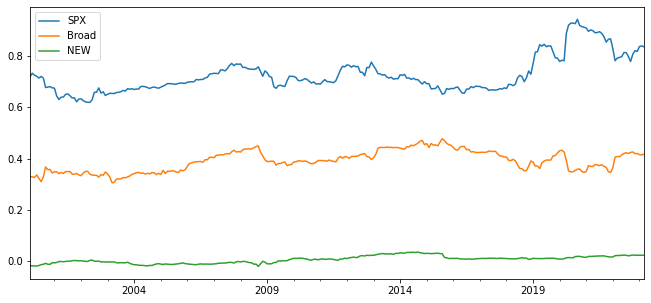

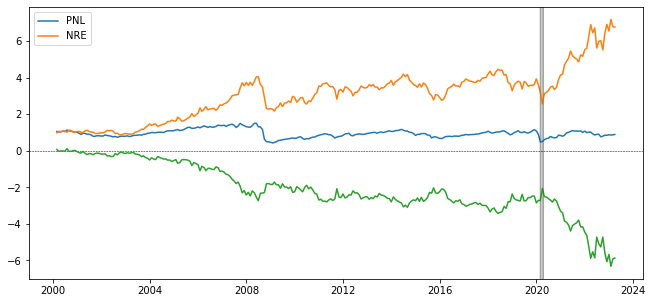

NEW (recent 10 years)          
                                NRE Replicate
Returns(%)                    10.54      2.66
Volatility(%)                 21.21     23.22
Sharpe                         0.35     -0.02

In [302]:
NEW_mean_r_data = []
NEW_mean_beta_data = []
NEW_total_horizon_data = []
NEW_total_returns_data = []
NEW_total_vol_data = []
NEW_total_sharpe_data = []

sector_name = 'Broad'

sector = sector_name
com_sector = com_dict[sector]

if sector_name != 'Broad':

    sector_nre = df[[sector]].apply(lambda x: x/100)
else:
    '''Broad 일 때,'''
    sector_nre = pd.DataFrame(np.diag(df @ df_size.T), index=df_size.index, columns=['Broad']).apply(lambda x:x/100)


setup_df = pd.concat([sector_nre, spx.pct_change(), com_df[[com_sector]].pct_change()], axis=1).dropna()

#NEW = yf.download('FRI', progress=False)[['Adj Close']].rename(columns={'Adj Close':'NEW'})
NEW = yf.download('^VIX', progress=False)[['Adj Close']].rename(columns={'Adj Close':'NEW'})
NEW = NEW.resample('m').last()
NEW.index = NEW.index + MonthEnd()

setup_df = pd.concat([setup_df, NEW.pct_change()], axis=1).dropna()

x = sm.add_constant(setup_df.iloc[:, 1:])
y = setup_df.iloc[:, [0]]

NEW_sector_beta_fit = RollingOLS(y, x, 120).fit()
NEW_sector_beta_reg = NEW_sector_beta_fit.params.dropna().iloc[:, 1:]

NEW_mean_beta = pd.DataFrame(NEW_sector_beta_fit.params.dropna().mean().iloc[1:], columns=[sector])
NEW_mean_beta.index = ['Equity_Beta', 'Commodity_Beta', 'New_Beta']
NEW_mean_beta_data.append(NEW_mean_beta)

NEW_mean_r = pd.DataFrame([NEW_sector_beta_fit.rsquared.dropna().mean()], columns=[sector], index=['R^2'])
NEW_mean_r_data.append(NEW_mean_r)

NEW_total_horizon = str(NEW_sector_beta_fit.params.iloc[0].name)[0:10] + ' ~ ' + str(NEW_sector_beta_fit.params.iloc[-1].name)[0:10]
NEW_total_horizon_data.append(NEW_total_horizon)

NEW_sector_beta_reg.plot(figsize=(11,5))

NEW_sector_beta_reg['cash'] = NEW_sector_beta_reg.apply(lambda x : (1-x.iloc[0]-x.iloc[1]+x.iloc[2]), axis=1).copy()
'''if VIX'''
NEW_sector_beta_reg['NEW'] = NEW_sector_beta_reg['NEW'].apply(lambda x: -x)

NEW_sector_beta_reg

'''다음기 수익률 매핑'''
NEW_ret_df = pd.concat([spx.pct_change(), com_df[['Broad']].pct_change(), rf.apply(lambda x: x/100), NEW.pct_change()], axis=1).dropna().shift(-1).loc[NEW_sector_beta_reg.index]
'''rf 수익률 사용할 때 1달 투자니 x/12로 해야함'''
NEW_ret_df.rf = NEW_ret_df.rf.apply(lambda x: x/12)
NEW_ret_df

NEW_broad_pnl = pd.DataFrame(np.diag(NEW_ret_df @ NEW_sector_beta_reg.values.T), columns=['pnl'], index=NEW_ret_df.index)
NEW_ex_broad_cum_ret = (1+NEW_broad_pnl).cumprod() - (1+broad_nre.loc[NEW_broad_pnl.index[0]:]).cumprod().values

sector_nre_returns = (sector_nre.loc[NEW_broad_pnl.index[0]:].mean() * 12 * 100).item()
sector_nre_vol = np.sqrt(sector_nre.loc[NEW_broad_pnl.index[0]:].var() * 12).item() * 100
sector_nre_sharpe = ((sector_nre.loc[NEW_broad_pnl.index[0]:] - rf.loc[NEW_broad_pnl.index[0]:'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / sector_nre_vol

NEW_broad_pnl_returns = (NEW_broad_pnl.mean() * 12 * 100).item()
NEW_broad_pnl_vol = np.sqrt(NEW_broad_pnl.var() * 12).item() * 100
NEW_broad_pnl_sharpe = ((NEW_broad_pnl - rf.loc[NEW_broad_pnl.index[0]:'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / NEW_broad_pnl_vol

NEW_total_returns_data.append(pd.DataFrame([sector_nre_returns, NEW_broad_pnl_returns], index=['NRE', 'Replicate'], columns=['Returns(%)']))
NEW_total_vol_data.append(pd.DataFrame([sector_nre_vol, NEW_broad_pnl_vol], index=['NRE', 'Replicate'], columns=['Volatility(%)']))
NEW_total_sharpe_data.append(pd.DataFrame([sector_nre_sharpe, NEW_broad_pnl_sharpe], index=['NRE', 'Replicate'], columns=['Sharpe']))

new_stat_reg = pd.concat([pd.concat(NEW_total_returns_data), pd.concat(NEW_total_vol_data), pd.concat(NEW_total_sharpe_data)], axis=1).T.apply(lambda x: np.round(x,2))
new_stat_reg.columns = pd.MultiIndex.from_tuples([(str('NEW'+f' (recent 10 years)'), y) for y in ['NRE', 'Replicate']])

plt.figure(figsize=(11,5))
plt.plot((1+NEW_broad_pnl).cumprod(), label='PNL')
plt.plot((1+broad_nre.loc[NEW_broad_pnl.index[0]:]).cumprod(), label='NRE')
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.legend()
plt.plot(NEW_ex_broad_cum_ret)

# plotting_crisis('1980-01-31', '1981-03-01') # 2nd oil shock 
# plotting_crisis('1987-10-19', '1987-10-24') # black monday
# plotting_crisis('1995-01-01', '2001-12-31') # Dotcom Bubble
# plotting_crisis('1997-07-01', '1998-12-31') # Asian Financial Crisis
#plotting_crisis('2007-07-01', '2008-12-31') # Subprime Mortgage Crisis
#plotting_crisis('2009-10-01', '2011-04-30') # Euro-zone Default Risk
plotting_crisis('2020-02-20', '2020-04-07') # Covid-19
plt.show()
new_stat_reg


In [306]:
NEW_sector_beta_reg

SPX     Broad       NEW      cash
2000-02-29  0.719317  0.329623  0.017064 -0.066005
2000-03-31  0.732839  0.329003  0.018403 -0.080244
2000-04-30  0.725107  0.326157  0.018897 -0.070160
2000-05-31  0.721225  0.335884  0.019049 -0.076158
2000-06-30  0.713945  0.322558  0.017137 -0.053640
...              ...       ...       ...       ...
2022-11-30  0.821032  0.419086 -0.022932 -0.217186
2022-12-31  0.817675  0.420001 -0.023003 -0.214673
2023-01-31  0.836956  0.415017 -0.023037 -0.228936
2023-02-28  0.839496  0.414571 -0.022983 -0.231084
2023-03-31  0.835818  0.416772 -0.023045 -0.229545

[278 rows x 4 columns]

# For MLP beta adj

120 window 별로 나누기 <br>
비교해야될 것?

84개월 train, 36개월 거래



In [180]:
sector = 'Broad'

if sector_name != 'Broad':

    sector_nre = df[[sector]].apply(lambda x: x/100)
else:
    '''Broad 일 때,'''
    sector_nre = pd.DataFrame(np.diag(df @ df_size.T), index=df_size.index, columns=['Broad']).apply(lambda x:x/100)


setup_df = pd.concat([sector_nre, spx.pct_change(), com_df[[com_sector]].pct_change()], axis=1).dropna()

#NEW = yf.download('FRI', progress=False)[['Adj Close']].rename(columns={'Adj Close':'NEW'})
#NEW = yf.download('^VIX', progress=False)[['Adj Close']].rename(columns={'Adj Close':'NEW'})
#NEW = NEW.resample('m').last()
#NEW.index = NEW.index + MonthEnd()

#setup_df = pd.concat([setup_df]), #NEW.pct_change()], axis=1).dropna()

x = setup_df.iloc[:, 1:]
y = setup_df.iloc[:, [0]]


In [197]:
def split_window (df, window):

    train_num = int(0.7 * window)
    trial_num = len(df) - window

    xc_train_list = []
    xf_train_list = []

    for x in range(trial_num):

        xc_train = df[x:train_num+x].values
        xf_train = df[train_num+x:window+x].values

        xc_train_list.append(xc_train)
        xf_train_list.append(xf_train)

    xc_train = np.array(xc_train_list)
    xf_train = np.array(xf_train_list)

    return xc_train, xf_train

In [206]:
xb_train, xf_train = split_window(setup_df.iloc[:, 1:], 120)

In [200]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model

In [209]:
xb_train

array([[[ 0.05269353,  0.02133281],
        [ 0.00145248,  0.00306602],
        [-0.09048311, -0.02063234],
        ...,
        [-0.00777457,  0.01485115],
        [ 0.05249756,  0.04688121],
        [-0.05053043, -0.01625553]],

       [[ 0.00145248,  0.00306602],
        [-0.09048311, -0.02063234],
        [-0.06096656, -0.03023505],
        ...,
        [ 0.05249756,  0.04688121],
        [-0.05053043, -0.01625553],
        [-0.02166029,  0.00270044]],

       [[-0.09048311, -0.02063234],
        [-0.06096656, -0.03023505],
        [-0.05003268,  0.06145027],
        ...,
        [-0.05053043, -0.01625553],
        [-0.02166029,  0.00270044],
        [-0.01402526,  0.06008336]],

       ...,

       [[ 0.0504281 ,  0.04451281],
        [ 0.01106065, -0.04020976],
        [ 0.03598772,  0.01054721],
        ...,
        [ 0.02043177,  0.00965728],
        [ 0.03404704,  0.0041248 ],
        [ 0.02858982,  0.06605126]],

       [[ 0.01106065, -0.04020976],
        [ 0.03598772,  0.01

In [211]:
window = 120
train_size = int(0.7 * window)
test_size = (120 - train_size)

In [ ]:

input_layer = keras.Input(
    batch_shape = ()
)

In [178]:
setup_df

Broad       SPX     Broad       NEW
2007-07-31  0.005716 -0.031982  0.054766 -0.091584
2007-08-31  0.005062  0.012864 -0.039997 -0.073570
2007-09-30  0.118840  0.035794  0.102620  0.022941
2007-10-31  0.079471  0.014822  0.097370  0.073605
2007-11-30 -0.044194 -0.044043 -0.035579  0.001072
...              ...       ...       ...       ...
2022-11-30  0.074335  0.053753 -0.024707  0.049066
2022-12-31 -0.053357 -0.058971 -0.017770  0.056705
2023-01-31  0.098361  0.061753 -0.006581 -0.051265
2023-02-28 -0.055572 -0.026112 -0.039916  0.103420
2023-03-31 -0.004388  0.035052 -0.013477 -0.046107

[189 rows x 4 columns]

In [ ]:
    xc_train_list = []
    xf_train_list = []

    for x in range(trial_num):

        xc_train = df_train[x:60+x].values
        xf_train = df_train[60+x:80+x].values

        xc_train_list.append(xc_train)
        xf_train_list.append(xf_train)

    xc_train = np.array(xc_train_list)
    xf_train = np.array(xf_train_list)


(-0.5, 1.5)

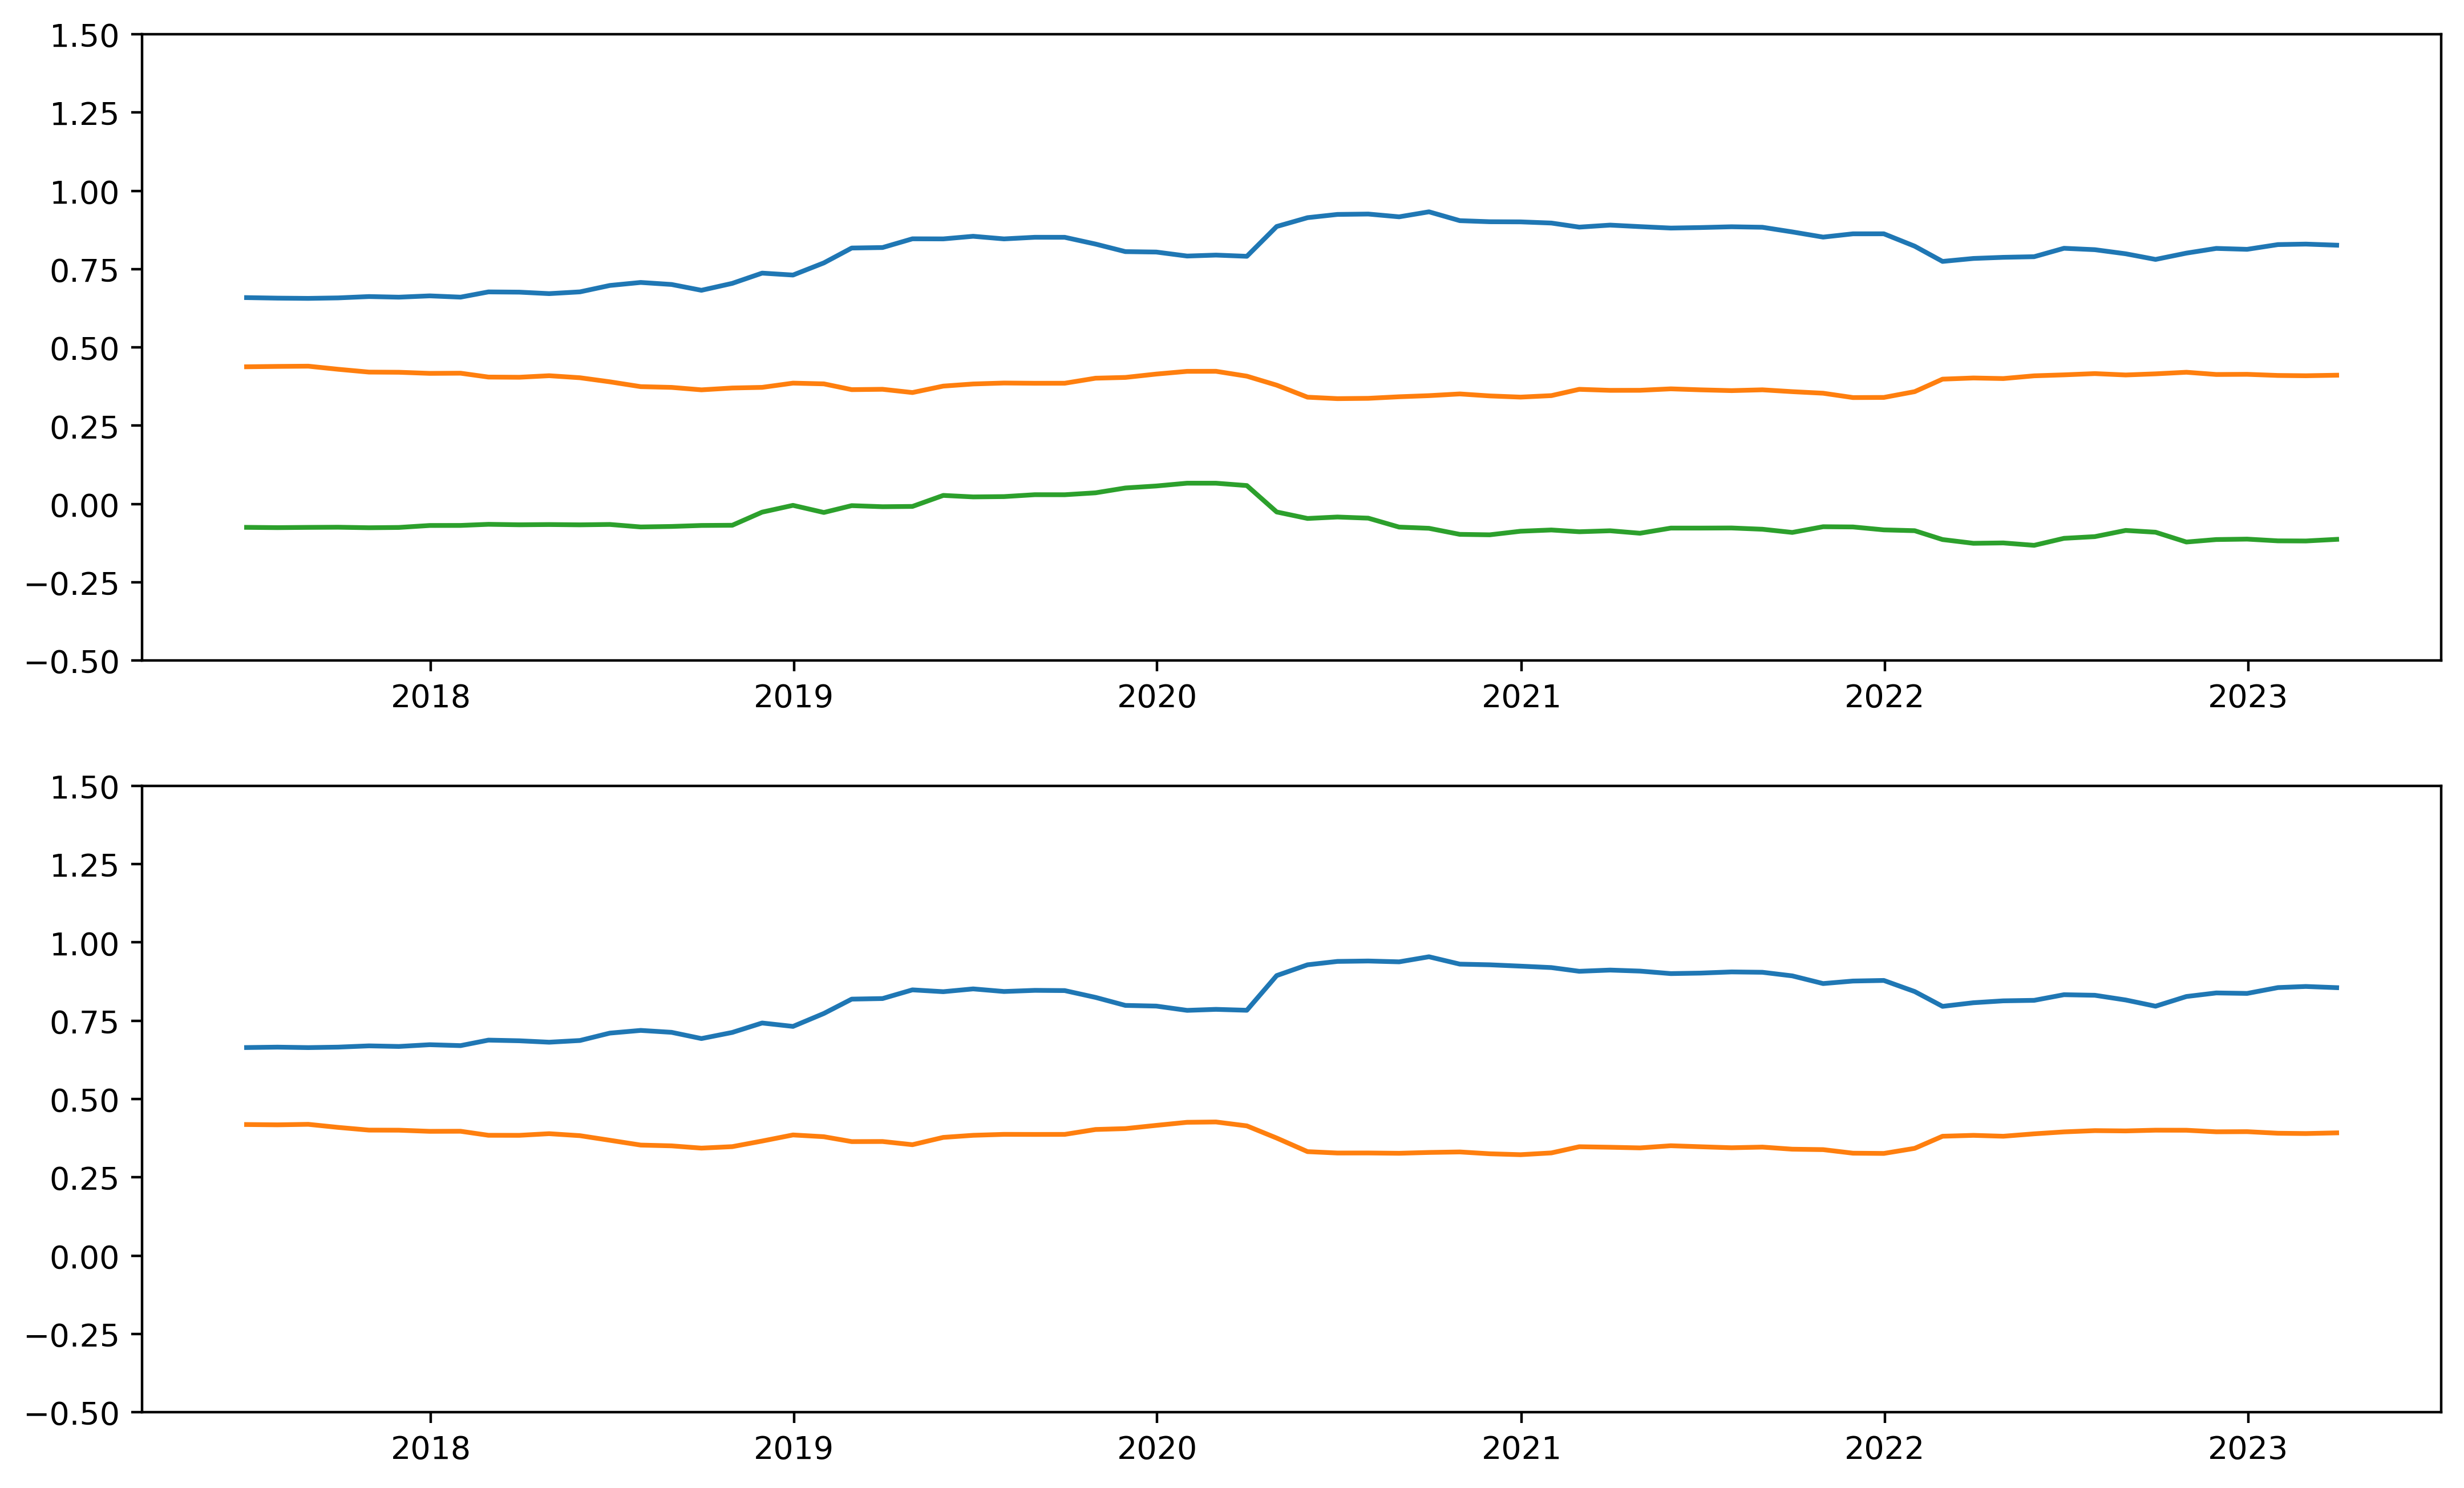

In [90]:
plt.figure(figsize=(13,8), dpi=400)
plt.subplot(2,1,1)
plt.plot(fri_sector_beta_reg)
plt.ylim(-0.5, 1.5)
plt.subplot(2,1,2)
plt.plot(reg.params.dropna().loc[fri_sector_beta_reg.index[0]:, reg.params.columns[1:]])
plt.ylim(-0.5, 1.5)

<AxesSubplot: >

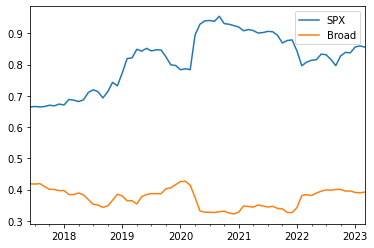

In [82]:
.plot()

In [33]:
# sector_beta_reg = sector_beta_fit.params.dropna().iloc[:, 1:]

# mean_beta = pd.DataFrame(sector_beta_fit.params.dropna().mean().iloc[1:], columns=[sector])
# mean_beta.index = ['Equity_Beta', 'Commodity_Beta']
# mean_beta_data.append(mean_beta)

# mean_r = pd.DataFrame([sector_beta_fit.rsquared.dropna().mean()], columns=[sector], index=['R^2'])
# mean_r_data.append(mean_r)

# total_horizon = str(sector_beta_fit.params.iloc[0].name)[0:10] + ' ~ ' + str(sector_beta_fit.params.iloc[-1].name)[0:10]
# total_horizon_data.append(total_horizon)

# '''투자비중 설정'''
# sector_beta_reg['cash'] = sector_beta_reg.apply(lambda x : (1-x.iloc[0]-x.iloc[1]), axis=1).copy()
# ret_df = pd.concat([spx.pct_change(), com_df[[com_sector]].pct_change(), rf.apply(lambda x: x/100)], axis=1).dropna().shift(-1).loc[sector_beta_reg.index]

# '''rf 수익률 사용할 때 1달 투자니 x/12로 해야함'''
# ret_df.rf = ret_df.rf.apply(lambda x: x/12)

# '''Replicate Port 수익률'''
# sector_pnl = pd.DataFrame(np.diag(ret_df @ sector_beta_reg.values.T), columns=['pnl'], index=ret_df.index)

# '''nre period all : 2013-03-31 ~ 2023-03-31'''
# sector_nre_returns = (sector_nre.loc['2013-03-31':].mean() * 12 * 100).item()
# sector_nre_vol = np.sqrt(sector_nre.loc['2013-03-31':].var() * 12).item() * 100
# sector_nre_sharpe = ((sector_nre.loc['2013-03-31':] - rf.loc['2013-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / sector_nre_vol

# print(f'***** {sector} NRE STATS (2013-03-31 ~ 2023-03-31) *****')
# print(f'Broad NRE Performance : {np.round(sector_nre_returns, 2)}%')
# print(f'Broad NRE Volatility : {np.round(sector_nre_vol, 2)}%')
# print(f'Broad NRE Sharpe : {np.round(sector_nre_sharpe, 5)}')
# print('\n')

# '''nre period all : 2013-03-31 ~ 2023-03-31'''
# sector_pnl_returns = (sector_pnl.loc['2013-03-31':].mean() * 12 * 100).item()
# sector_pnl_vol = np.sqrt(sector_pnl.loc['2013-03-31':].var() * 12).item() * 100
# sector_pnl_sharpe = ((sector_pnl.loc['2013-03-31':] - rf.loc['2013-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / sector_pnl_vol

# print(f'***** {sector} Replicate STATS (2013-03-31 ~ 2023-03-31) *****')
# print(f'Broad NRE Performance : {np.round(sector_pnl_returns, 2)}%')
# print(f'Broad NRE Volatility : {np.round(sector_pnl_vol, 2)}%')
# print(f'Broad NRE Sharpe : {np.round(sector_pnl_sharpe, 5)}')
# print('\n')

# total_returns_data.append(pd.DataFrame([sector_nre_returns, sector_pnl_returns], index=['NRE', 'Replicate'], columns=['Returns(%)']))
# total_vol_data.append(pd.DataFrame([sector_nre_vol, sector_pnl_vol], index=['NRE', 'Replicate'], columns=['Volatility(%)']))
# total_sharpe_data.append(pd.DataFrame([sector_nre_sharpe, sector_pnl_sharpe], index=['NRE', 'Replicate'], columns=['Sharpe']))


    

In [34]:
# aa = pd.concat([pd.concat(total_returns_data), pd.concat(total_vol_data), pd.concat(total_sharpe_data)], axis=1).T.apply(lambda x: np.round(x,2))
# aa.columns = pd.MultiIndex.from_tuples([(sector_name, 'NRE'), (sector_name, 'Replicate')])
# aa

ValueError: No objects to concatenate

In [ ]:
sector_pnl

pnl
1980-01-31 -0.007125
1980-02-29 -0.117042
1980-03-31  0.045959
1980-04-30  0.054510
1980-05-31  0.036731
...              ...
2022-11-30 -0.057252
2022-12-31  0.048417
2023-01-31 -0.038756
2023-02-28  0.024148
2023-03-31  0.005634

[519 rows x 1 columns]

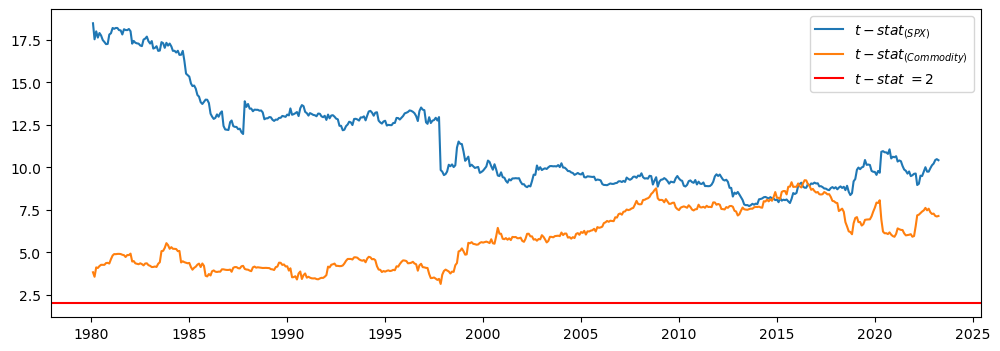

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(pd.DataFrame(reg.tvalues, index=reg.params.index, columns=reg.params.columns).dropna().iloc[:,1:]['SPX'], label=r'$t-stat_{(SPX)}$')
plt.plot(pd.DataFrame(reg.tvalues, index=reg.params.index, columns=reg.params.columns).dropna().iloc[:,1:]['Broad'], label=r'$t-stat_{(Commodity)}$')
plt.axhline(2, color='r', label=r'$t-stat\,\, = 2$')
plt.legend()
plt.show()

In [ ]:
print('''Mean T_stat''')
pd.DataFrame(reg.tvalues, index=reg.params.index, columns=reg.params.columns).dropna().iloc[:,1:].mean()

Mean T_stat


SPX      11.360522
Broad     5.817694
dtype: float64

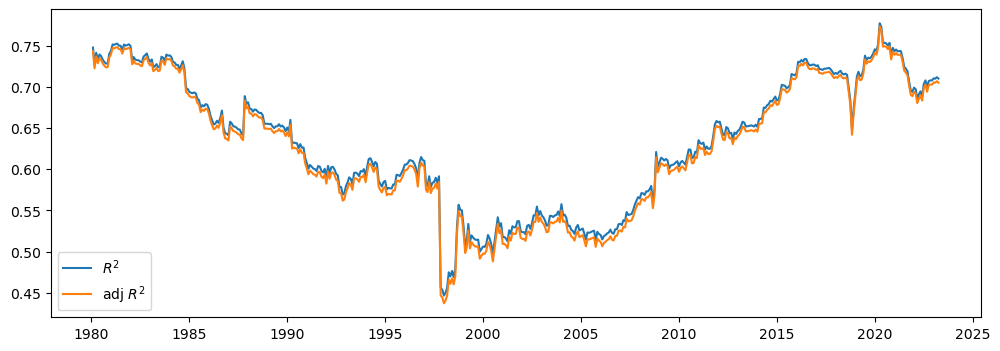

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(reg.rsquared, label=r'$R^2$')
plt.plot(reg.rsquared_adj, label=r'adj $R^2$')
plt.legend()
plt.show()

In [ ]:
print('''mean R''')
reg.rsquared.mean(), reg.rsquared_adj.mean()

mean R


(0.6325331052747744, 0.6262516198948564)

In [ ]:
broad_betas = reg.params.dropna().iloc[:,1:]
broad_betas

SPX     Broad
1980-01-31  0.968179  0.142803
1980-02-29  0.964936  0.138875
1980-03-31  1.000875  0.162565
1980-04-30  0.992793  0.160885
1980-05-31  1.002627  0.163552
...              ...       ...
2022-11-30  0.838845  0.395405
2022-12-31  0.837297  0.395837
2023-01-31  0.855929  0.390813
2023-02-28  0.859454  0.389846
2023-03-31  0.855680  0.392016

[519 rows x 2 columns]

## replicate port

### $$ \beta_{\text{SI}}\quad \beta_{\text{CI}}\quad(1-\beta_{\text{SI}}-\beta_{\text{CI}})$$

In [ ]:
broad_betas['cash'] = broad_betas.apply(lambda x : (1-x.iloc[0]-x.iloc[1]), axis=1).copy()
broad_betas

SPX     Broad      cash
1980-01-31  0.968179  0.142803 -0.110983
1980-02-29  0.964936  0.138875 -0.103811
1980-03-31  1.000875  0.162565 -0.163440
1980-04-30  0.992793  0.160885 -0.153677
1980-05-31  1.002627  0.163552 -0.166179
...              ...       ...       ...
2022-11-30  0.838845  0.395405 -0.234250
2022-12-31  0.837297  0.395837 -0.233134
2023-01-31  0.855929  0.390813 -0.246743
2023-02-28  0.859454  0.389846 -0.249300
2023-03-31  0.855680  0.392016 -0.247696

[519 rows x 3 columns]

In [ ]:
'''다음기 수익률 매핑'''
ret_df = pd.concat([spx.pct_change(), com_df[['Broad']].pct_change(), rf.apply(lambda x: x/100)], axis=1).dropna().shift(-1).loc[broad_betas.index]
'''rf 수익률 사용할 때 1달 투자니 x/12로 해야함'''
ret_df.rf = ret_df.rf.apply(lambda x: x/12)
ret_df

SPX     Broad        rf
1980-01-31 -0.004380 -0.011959  0.010600
1980-02-29 -0.101795 -0.127618  0.010533
1980-03-31  0.041140  0.038433  0.008967
1980-04-30  0.046571  0.059591  0.008542
1980-05-31  0.026969  0.067799  0.008408
...              ...       ...       ...
2022-11-30 -0.058971 -0.017770  0.003233
2022-12-31  0.061753 -0.006581  0.002933
2023-01-31 -0.026112 -0.039916  0.003267
2023-02-28  0.035052 -0.013477  0.002900
2023-03-31  0.014642 -0.015777  0.002867

[519 rows x 3 columns]

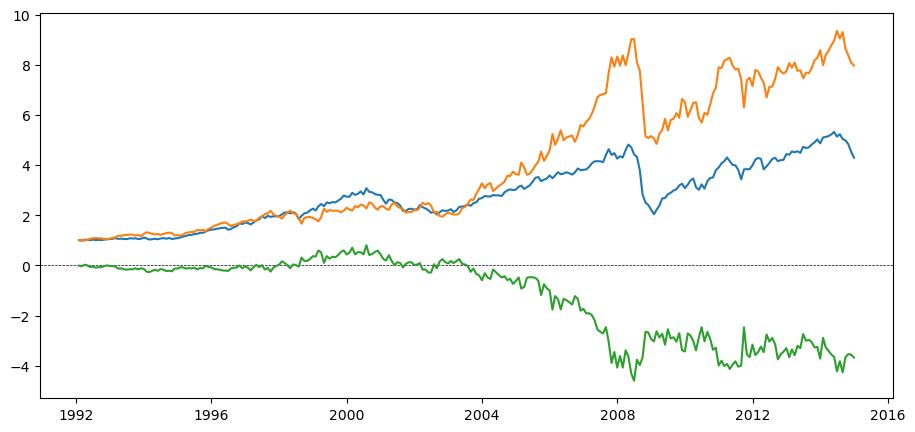

In [ ]:
broad_pnl = pd.DataFrame(np.diag(ret_df @ broad_betas.values.T), columns=['pnl'], index=ret_df.index)
ex_broad_cum_ret = (1+broad_pnl.loc['1992':'2014']).cumprod() - (1+broad_nre.loc['1992':'2014']).cumprod().values

plt.figure(figsize=(11,5))
plt.plot((1+broad_pnl.loc['1992':'2014']).cumprod())
plt.plot((1+broad_nre.loc['1992':'2014']).cumprod())
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.plot(ex_broad_cum_ret)


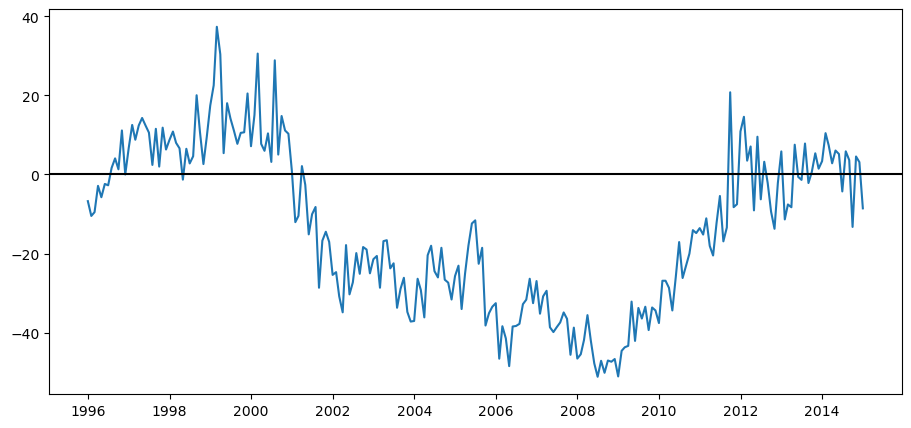

In [ ]:
test = (broad_pnl - broad_nre.loc[broad_pnl.index].values)

plt.figure(figsize=(11,5))
plt.plot(((test.loc['1993':'2014'] + 1).rolling(36).apply(pd.Series.prod) - 1).apply(lambda x: x*100).dropna())
plt.axhline(0, color='k')
plt.show()

In [ ]:
'''nre period all : 1980-01-31 ~ 2023-03-31'''
broad_nre_returns = (broad_nre.loc[broad_pnl.index].mean() * 12 * 100).item()
broad_nre_vol = np.sqrt(broad_nre.loc[broad_pnl.index].var() * 12).item() * 100
broad_nre_sharpe = ((broad_nre.loc[broad_pnl.index] - rf.loc[broad_pnl.index].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / broad_nre_vol

print('***** Broad NRE STATS (1980-01-31 ~ 2023-03-31) *****')
print(f'Broad NRE Performance : {np.round(broad_nre_returns, 2)}%')
print(f'Broad NRE Volatility : {np.round(broad_nre_vol, 2)}%')
print(f'Broad NRE Sharpe : {np.round(broad_nre_sharpe, 5)}')


***** Broad NRE STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 11.01%
Broad NRE Volatility : 20.04%
Broad NRE Sharpe : 0.26458


In [ ]:
'''nre period all : 1980-01-31 ~ 2023-03-31'''
broad_pnl_returns = (broad_pnl.mean() * 12 * 100).item()
broad_pnl_vol = np.sqrt(broad_pnl.var() * 12).item() * 100
broad_pnl_sharpe = ((broad_pnl - rf.loc[broad_pnl.index].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / broad_pnl_vol

print('***** Broad Replicate STATS (1980-01-31 ~ 2023-03-31) *****')
print(f'Broad NRE Performance : {np.round(broad_pnl_returns, 2)}%')
print(f'Broad NRE Volatility : {np.round(broad_pnl_vol, 2)}%')
print(f'Broad NRE Sharpe : {np.round(broad_pnl_sharpe, 5)}')


***** Broad Replicate STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 8.53%
Broad NRE Volatility : 16.06%
Broad NRE Sharpe : 0.17595


In [ ]:
'''nre period all : 2011-03-31 ~ 2023-03-31'''
broad_nre_returns_2 = (broad_nre.loc['2011-03-31':].mean() * 12 * 100).item()
broad_nre_vol_2 = np.sqrt(broad_nre.loc['2011-03-31':].var() * 12).item() * 100
broad_nre_sharpe_2 = ((broad_nre.loc['2011-03-31':] - rf.loc['2011-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100)  / broad_nre_vol_2

print('***** Broad NRE STATS (2011-03-31 ~ 2023-03-31) *****')
print(f'Broad NRE Performance : {np.round(broad_nre_returns_2, 2)}%')
print(f'Broad NRE Volatility : {np.round(broad_nre_vol_2, 2)}%')
print(f'Broad NRE Sharpe : {np.round(broad_nre_sharpe_2, 5)}')

***** Broad NRE STATS (2011-03-31 ~ 2023-03-31) *****
Broad NRE Performance : 7.41%
Broad NRE Volatility : 21.61%
Broad NRE Sharpe : 0.24258


In [ ]:
'''Replicate period all : 2011-03-31 ~ 2023-03-31'''
broad_pnl_returns_2 = (broad_pnl.loc['2011-03-31':].mean() * 12 * 100).item()
broad_pnl_vol_2 = np.sqrt(broad_pnl.loc['2011-03-31':].var() * 12).item() * 100
broad_pnl_sharpe_2 = ((broad_pnl.loc['2011-03-31':] - rf.loc['2011-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / broad_pnl_vol_2

print('***** Broad Replicate STATS (2011-03-31 ~ 2023-03-31) *****')
print(f'Broad NRE Performance : {np.round(broad_pnl_returns_2, 2)}%')
print(f'Broad NRE Volatility : {np.round(broad_pnl_vol_2, 2)}%')
print(f'Broad NRE Sharpe : {np.round(broad_pnl_sharpe_2, 5)}')


***** Broad Replicate STATS (2011-03-31 ~ 2023-03-31) *****
Broad NRE Performance : 7.5%
Broad NRE Volatility : 17.39%
Broad NRE Sharpe : 0.30654


# All Sectors

In [ ]:
'''Oil'''
oil_nre = df[['Oil']].apply(lambda x: x/100)
oil = pd.concat([oil_nre, com_df[['Pet']].pct_change(), spx.pct_change() ], axis=1).dropna()

x_oil = sm.add_constant(oil.iloc[:,1:])
y_oil = oil.iloc[:, [0]]

oil_reg = RollingOLS(y_oil, x_oil, 120).fit()
oil_reg = oil_reg.params.dropna().iloc[:, 1:]

oil_reg

Pet       SPX
1993-01-31  0.257558  0.785186
1993-02-28  0.257901  0.785661
1993-03-31  0.256896  0.784817
1993-04-30  0.255342  0.776350
1993-05-31  0.255782  0.778622
...              ...       ...
2022-11-30  0.387230  0.901490
2022-12-31  0.388173  0.895064
2023-01-31  0.389498  0.886632
2023-02-28  0.390156  0.890988
2023-03-31  0.390978  0.890077

[363 rows x 2 columns]

In [ ]:
oil_reg['cash'] = oil_reg.apply(lambda x : (1-x.iloc[0]-x.iloc[1]), axis=1).copy()
oil_reg

Pet       SPX      cash
1993-01-31  0.257558  0.785186 -0.042744
1993-02-28  0.257901  0.785661 -0.043562
1993-03-31  0.256896  0.784817 -0.041713
1993-04-30  0.255342  0.776350 -0.031692
1993-05-31  0.255782  0.778622 -0.034405
...              ...       ...       ...
2022-11-30  0.387230  0.901490 -0.288720
2022-12-31  0.388173  0.895064 -0.283238
2023-01-31  0.389498  0.886632 -0.276130
2023-02-28  0.390156  0.890988 -0.281145
2023-03-31  0.390978  0.890077 -0.281055

[363 rows x 3 columns]

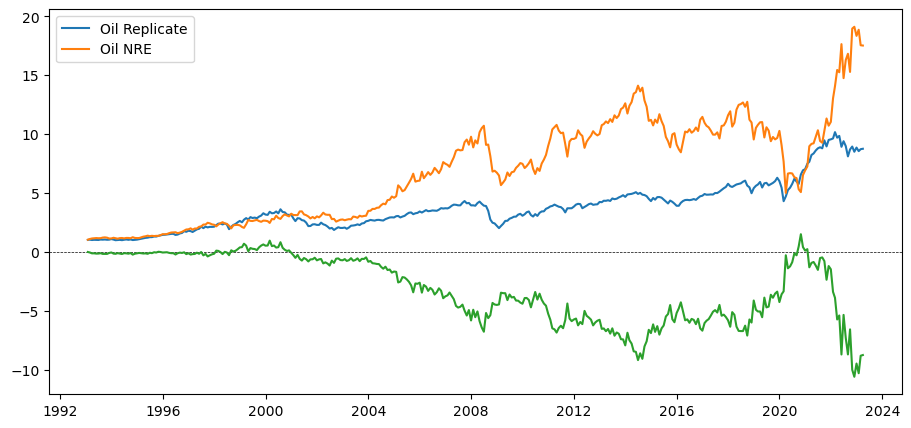

In [ ]:
oil_ret_df = pd.concat([spx.pct_change(), com_df[['Broad']].pct_change(), rf.apply(lambda x: x/100)], axis=1).dropna().shift(-1).loc[oil_reg.index]
'''rf 수익률 사용할 때 1달 투자니 x/12로 해야함'''
oil_ret_df.rf = oil_ret_df.rf.apply(lambda x: x/12)

oil_pnl = pd.DataFrame(np.diag(oil_ret_df @ broad_betas.values.T), columns=['pnl'], index=oil_ret_df.index)
cum_oil_pnl = (oil_pnl + 1).cumprod()
cum_oil_nre = (oil_nre.loc[oil_ret_df.index] + 1).cumprod()
ex_oil_cum_ret = cum_oil_pnl - cum_oil_nre.values

plt.figure(figsize=(11,5))
plt.plot(cum_oil_pnl, label='Oil Replicate')
plt.plot(cum_oil_nre, label='Oil NRE')
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.plot(ex_oil_cum_ret)
plt.legend()
plt.show()


In [ ]:
oil_nre

Oil
1969-07-31 -0.0973
1969-08-31  0.0660
1969-09-30 -0.0971
1969-10-31 -0.0117
1969-11-30 -0.0457
...            ...
2022-11-30  0.0082
2022-12-31 -0.0404
2023-01-31  0.0284
2023-02-28 -0.0699
2023-03-31 -0.0014

[645 rows x 1 columns]

In [ ]:
oil_pnl

pnl
1993-01-31  0.012048
1993-02-28  0.020253
1993-03-31 -0.028404
1993-04-30  0.016235
1993-05-31 -0.004781
...              ...
2022-11-30 -0.049242
2022-12-31  0.041518
2023-01-31 -0.034096
2023-02-28  0.019513
2023-03-31  0.003928

[363 rows x 1 columns]

In [ ]:
'''nre period all : 1993-01-31 ~ 2023-03-31'''
oil_nre_returns = (oil_nre.loc[oil_pnl.index].mean() * 12 * 100).item()
oil_nre_vol = np.sqrt(oil_nre.loc[oil_pnl.index].var() * 12).item() * 100
oil_nre_sharpe = ((oil_nre.loc[oil_pnl.index] - rf.loc[oil_pnl.index].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / oil_nre_vol

print('***** Oil NRE STATS (1993-01-31 ~ 2023-03-31) *****')
print(f'oil NRE Performance : {np.round(oil_nre_returns, 2)}%')
print(f'oil NRE Volatility : {np.round(oil_nre_vol, 2)}%')
print(f'oil NRE Sharpe : {np.round(oil_nre_sharpe, 5)}')
print('\n')

'''nre period all : 1993-01-31 ~ 2023-03-31'''
oil_pnl_returns = (oil_pnl.mean() * 12 * 100).item()
oil_pnl_vol = np.sqrt(oil_pnl.var() * 12).item() * 100
oil_pnl_sharpe = ((oil_pnl - rf.loc[oil_pnl.index].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / oil_pnl_vol

print('***** Oil REPLICATE STATS (1993-01-31 ~ 2023-03-31) *****')
print(f'oil NRE Performance : {np.round(oil_pnl_returns, 2)}%')
print(f'oil NRE Volatility : {np.round(oil_pnl_vol, 2)}%')
print(f'oil NRE Sharpe : {np.round(oil_pnl_sharpe, 5)}')
print('\n')

'''nre period all : 2011-03-31 ~ 2023-03-31'''
oil_nre_returns_2 = (oil_nre.loc['2011-03-31':].mean() * 12 * 100).item()
oil_nre_vol_2 = np.sqrt(oil_nre.loc['2011-03-31':].var() * 12).item() * 100
oil_nre_sharpe_2 = ((oil_nre.loc['2011-03-31':] - rf.loc['2011-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100)  / oil_nre_vol_2

print('***** Oil NRE STATS (2011-03-31 ~ 2023-03-31) *****')
print(f'oil NRE Performance : {np.round(oil_nre_returns_2, 2)}%')
print(f'oil NRE Volatility : {np.round(oil_nre_vol_2, 2)}%')
print(f'oil NRE Sharpe : {np.round(oil_nre_sharpe_2, 5)}')
print('\n')

'''Replicate period all : 2011-03-31 ~ 2023-03-31'''
oil_pnl_returns_2 = (oil_pnl.loc['2011-03-31':].mean() * 12 * 100).item()
oil_pnl_vol_2 = np.sqrt(oil_pnl.loc['2011-03-31':].var() * 12).item() * 100
oil_pnl_sharpe_2 = ((oil_pnl.loc['2011-03-31':] - rf.loc['2011-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / oil_pnl_vol_2

print('***** Oil REPLICATE STATS (2011-03-31 ~ 2023-03-31) *****')
print(f'oil NRE Performance : {np.round(oil_pnl_returns_2, 2)}%')
print(f'oil NRE Volatility : {np.round(oil_pnl_vol_2, 2)}%')
print(f'oil NRE Sharpe : {np.round(oil_pnl_sharpe_2, 5)}')


***** Oil NRE STATS (1993-01-31 ~ 2023-03-31) *****
oil NRE Performance : 12.22%
oil NRE Volatility : 23.34%
oil NRE Sharpe : 0.35704


***** Oil REPLICATE STATS (1993-01-31 ~ 2023-03-31) *****
oil NRE Performance : 8.55%
oil NRE Volatility : 16.28%
oil NRE Sharpe : 0.28631


***** Oil NRE STATS (2011-03-31 ~ 2023-03-31) *****
oil NRE Performance : 8.44%
oil NRE Volatility : 28.78%
oil NRE Sharpe : 0.21773


***** Oil REPLICATE STATS (2011-03-31 ~ 2023-03-31) *****
oil NRE Performance : 7.99%
oil NRE Volatility : 15.88%
oil NRE Sharpe : 0.36656
